
# Auditing LLM Evaluation: Helpfulness, Bias, and Capability Taxonomies  
**Consolidated Workflow Notebook**  
*Last Edited - 2025-09-29*

**Author:** _Ethan Norton_  
**Affiliations:** _MSML Applicant; ICSD-aligned evaluation research, MSDS Northwestern_

This paper develops an end-to-end, reproducible workflow for evaluating Large Language Models (LLMs) on multi-attribute human annotations (helpfulness, correctness, coherence, complexity, verbosity), probing bias (e.g., verbosity), testing robustness to semantic-preserving perturbations, and mapping results to a biases [TBD]



## Abstract

Large language models (LLMs) are increasingly deployed in high-stakes domains, yet their evaluation remains hindered by biases, unstable annotations, and ad‑hoc capability taxonomies. This paper leverages recent human‑annotated datasets (e.g., HelpSteer) to investigate how response attributes predict helpfulness. Using supervised classifiers and perturbation‑based robustness tests, this paper examines true positive, false positive, and F1 scores across models while probing systematic sources of bias. Results indicate that correctness is the strongest predictor of helpfulness, but verbosity exerts an outsized influence, inflating perceived quality even in factually incorrect responses. Further, semantically equivalent prompts often yield inconsistent judgments from LLMs. To address these issues, this paper adopts a capability taxonomy (absent / partial / robust) and incorporates expertise‑sensitive considerations from peer‑review research. The findings highlight the need for theoretically grounded evaluation frameworks that combine reproducible annotations, bias audits, and social‑dynamics perspectives on judgment.

## Keywords

Large Language Models; HelpSteer Dataset; Human Annotation; Helpfulness Evaluation; In‑Context Learning; Bias and Fairness; Reproducibility; Social Dynamics; Evaluation Frameworks; Safe AI



## Table of Contents

1. [Setup](#Setup)  
2. [Data](#Data)  
3. [Research Design & Methods](#Design)  
4. [Design & Implementation Considerations](#Implementation)  
5. [Exploratory Analysis](#EDA)  
6. [Modeling & Metrics (F1, TP/FP)](#Modeling)  
7. [Bias Probes: Verbosity & Partial Correlations](#Bias)  
8. [Robustness: Semantic‑Preserving Perturbations](#Robustness)  
9. [Capability Taxonomy Mapping](#Taxonomy)  
10. [Results](#Results)  
11. [Conclusions](#Conclusions)  
12. [Future Directions](#Future)  
13. [References](#References)


## Setup<a id='Setup'></a>

In [1]:

# Core libraries
import os, re, math, json, random
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# Modeling & metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_fscore_support

# Utility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

print("Environment ready.")


Environment ready.



## Data<a id='Data'></a>

Expected schema (CSV/Parquet):  
- `prompt` *(str)*  
- `response` *(str)*  
- `helpfulness` *(int, 0–4)*  
- `correctness` *(int, 0–4)*  
- `coherence` *(int, 0–4)*  
- `complexity` *(int, 0–4)*  
- `verbosity` *(float|int; optional — if missing, computed as character length)*  
- optional: `language`, `split`, `source`

> **Note:** If using HelpSteer‑like data, ensure ratings are independent (not pairwise). If fields differ, adjust the `COLUMN_MAP` below.


In [13]:

DATA_PATH = r"C:\Users\ethan\Downloads\classes\ai-alignment\train.csv"

# Column mapping if your dataset uses different names
COLUMN_MAP = {
    "prompt": "prompt",
    "response": "response",
    "helpfulness": "helpfulness",
    "correctness": "correctness",
    "coherence": "coherence",
    "complexity": "complexity",
    "verbosity": "verbosity"  # if missing, we'll compute chars
}

def load_dataset(path: str, column_map: dict) -> pd.DataFrame:
    if path.endswith(".csv"):
        df = pd.read_csv(path)
    elif path.endswith(".parquet"):
        df = pd.read_parquet(path)
    else:
        raise ValueError("Please provide a .csv or .parquet file.")
    # Rename to standard columns when present
    rename = {v:k for k,v in column_map.items() if v in df.columns}
    df = df.rename(columns=rename)
    # Compute verbosity if missing
    if "verbosity" not in df.columns and "response" in df.columns:
        df["verbosity"] = df["response"].astype(str).str.len()
    # Enforce numeric types
    for col in ["helpfulness","correctness","coherence","complexity"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")
    # Drop rows with missing key labels
    df = df.dropna(subset=["helpfulness","correctness","coherence","complexity","verbosity"])
    return df

try:
    df = load_dataset(DATA_PATH, COLUMN_MAP)
    print("Loaded dataset shape:", df.shape)
    display_cols = ["prompt","response","helpfulness","correctness","coherence","complexity","verbosity"]
    print(df[display_cols].head(3))
except Exception as e:
    print("Note: Set DATA_PATH to your dataset. Error:", e)


Loaded dataset shape: (35331, 7)
                                              prompt  \
0  What are the three most important things to co...   
1  What are the three most important things to co...   
2  What are the three most important things to co...   

                                            response  helpfulness  \
0  To build an assistive device to help an elderl...            3   
1  There are many different types of assistive de...            4   
2  When deciding what technology to use to build ...            4   

   correctness  coherence  complexity  verbosity  
0            4          4           2          2  
1            3          3           2          3  
2            4          4           2          2  



## Research Design & Methods<a id='Design'></a>

- **Predictive task:** classify *helpfulness* as **High (≥3)** vs **Low (≤2)**.  
- **Models:** Logistic Regression baseline with standardized features.  
- **Predictors:** correctness, coherence, complexity, verbosity (+ optional engineered features).  
- **Metrics:** F1 score, precision/recall, confusion matrix; TP/FP/FN rates; ROC‑AUC.  
- **Bias probes:** partial correlations and controlled models excluding verbosity.  
- **Robustness:** semantic‑preserving perturbations (punctuation, casing, whitespace, order shuffles).  
- **Capability taxonomy:** absent / partial / robust thresholds based on F1 and stability.



## Design & Implementation Considerations<a id='Implementation'></a>

- **Annotation reliability:** ratings are independent and trained annotators used; nonetheless, open‑ended QA ground truth can be underspecified.  
- **Feature leakage:** verbosity may inflate helpfulness; compare models with/without verbosity.  
- **Expertise effects:** annotator expertise may influence labels; consider stratification if metadata available.  
- **Reproducibility:** fixed seeds, data splits logged, and all parameters surfaced in the notebook.



## Exploratory Analysis<a id='EDA'></a>


Label distribution (helpfulness):
helpfulness
0     1223
1     2295
2     7310
3    16452
4     8051
Name: count, dtype: int64

Pearson correlations:
              helpfulness  correctness  coherence  complexity  verbosity
helpfulness     1.000000     0.852189   0.634446    0.235142   0.256832
correctness     0.852189     1.000000   0.625143    0.247207   0.256181
coherence       0.634446     0.625143   1.000000    0.125127   0.142405
complexity      0.235142     0.247207   0.125127    1.000000   0.630548
verbosity       0.256832     0.256181   0.142405    0.630548   1.000000


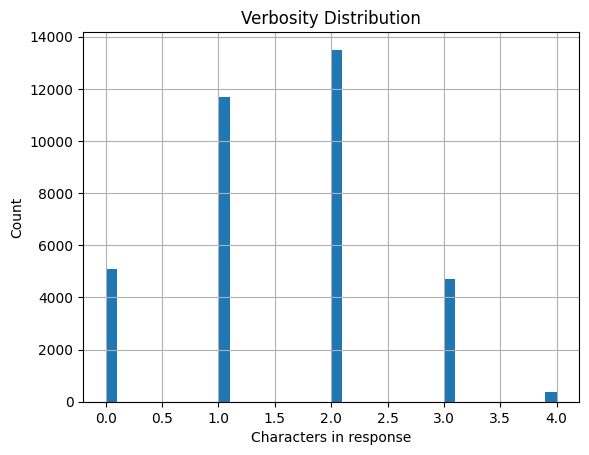

In [14]:

if 'df' in globals():
    print("Label distribution (helpfulness):")
    print(df['helpfulness'].value_counts(dropna=False).sort_index())
    
    # Basic correlations
    core = df[["helpfulness","correctness","coherence","complexity","verbosity"]].corr()
    print("\nPearson correlations:\n", core)

    # Simple histogram of verbosity
    plt.figure()
    df['verbosity'].hist(bins=40)
    plt.title("Verbosity Distribution")
    plt.xlabel("Characters in response")
    plt.ylabel("Count")
    plt.show()
else:
    print("Load data first.")


Correlation of each metric with total_score:
correctness: 0.765
verbosity: 0.723
helpfulness: 0.705
complexity: 0.698
coherence: 0.649


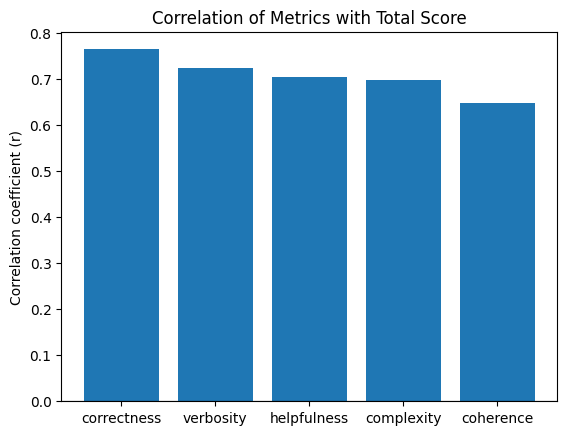

In [20]:
import pandas as pd

# Assume df already loaded with columns:
# correctness, coherence, complexity, verbosity, helpfulness

# Step 1: create a summation column
df["total_score"] = df[["correctness", "coherence", "complexity", "verbosity"]].sum(axis=1)

# Step 2: compute correlations of each metric with total
correlations = {}
for col in ["correctness", "coherence", "complexity", "verbosity", "helpfulness"]:
    correlations[col] = df[col].corr(df["total_score"])

# Step 3: show sorted correlations
correlations = dict(sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True))
print("Correlation of each metric with total_score:")
for k, v in correlations.items():
    print(f"{k}: {v:.3f}")

# Optional: quick barplot
import matplotlib.pyplot as plt

plt.bar(correlations.keys(), correlations.values())
plt.axhline(0, color="black", linewidth=0.8)
plt.title("Correlation of Metrics with Total Score")
plt.ylabel("Correlation coefficient (r)")
plt.show()


=== Correlations with correctness ===
                      correctness
correctness                 1.000
helpfulness                 0.852
coherence                   0.625
verbosity                   0.256
complexity                  0.247
resp_smog_index             0.184
resp_word_count             0.178
verbosity_alt               0.163
complexity_alt              0.156
resp_fog_index              0.153
resp_fk_grade               0.143
resp_dale_chall             0.132
resp_long_word_ratio        0.128
resp_avg_word_len           0.106
resp_avg_sent_len           0.099
resp_syll_per_word          0.088
resp_herdan_c               0.066
pr_ratio                   -0.030
resp_punct_ratio           -0.088
resp_flesch_re             -0.117
resp_ttr                   -0.126
resp_polarity                 NaN
resp_subjectivity             NaN


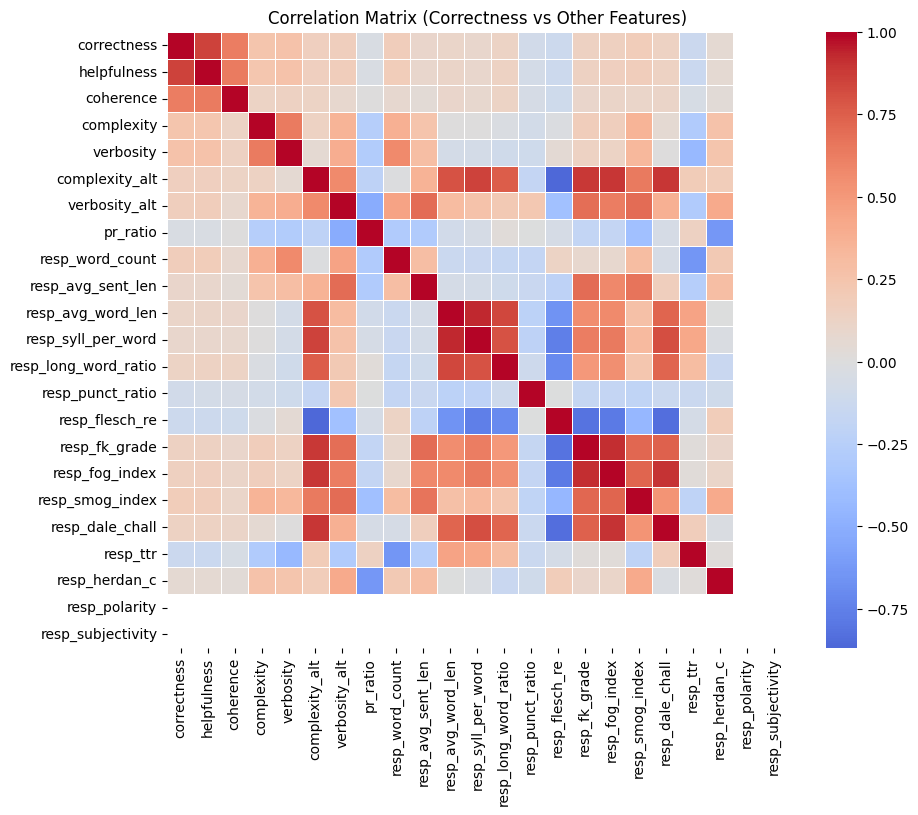

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pick which features to include in the correlation analysis
corr_vars = [
    "correctness", "helpfulness", "coherence", "complexity", "verbosity",
    "complexity_alt","verbosity_alt","pr_ratio",
    "resp_word_count","resp_avg_sent_len","resp_avg_word_len",
    "resp_syll_per_word","resp_long_word_ratio","resp_punct_ratio",
    "resp_flesch_re","resp_fk_grade","resp_fog_index","resp_smog_index","resp_dale_chall",
    "resp_ttr","resp_herdan_c","resp_polarity","resp_subjectivity"
]

# Keep only those columns present
corr_vars = [c for c in corr_vars if c in df.columns]

# Compute correlation matrix
corr_matrix = df[corr_vars].corr()

# Focus only on correlations relative to correctness
corr_correctness = corr_matrix[["correctness"]].sort_values(by="correctness", ascending=False)

print("=== Correlations with correctness ===")
print(corr_correctness.round(3))

# Heatmap (correctness row/column highlighted)
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, annot=False, linewidths=0.5)
plt.title("Correlation Matrix (Correctness vs Other Features)")
plt.show()


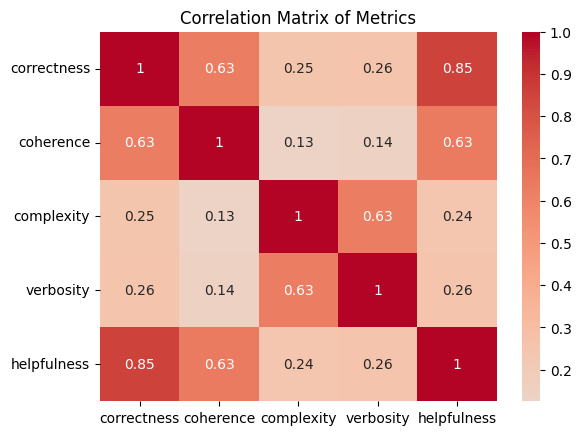

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(df[["correctness","coherence","complexity","verbosity","helpfulness"]].corr(),
            annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Matrix of Metrics")
plt.show()


In [22]:
# Bin correctness
df["correctness_bin"] = pd.cut(df["correctness"], bins=[-1,1,2,4], labels=["low","mid","high"])

# Conditional probabilities
for metric in ["helpfulness","coherence","complexity","verbosity"]:
    probs = df.groupby("correctness_bin")[metric].apply(lambda x: (x>=3).mean())
    print(f"\nP({metric} ≥ 3 | correctness_bin):")
    print(probs)



P(helpfulness ≥ 3 | correctness_bin):
correctness_bin
low     0.010074
mid     0.236275
high    0.914565
Name: helpfulness, dtype: float64

P(coherence ≥ 3 | correctness_bin):
correctness_bin
low     0.413037
mid     0.735634
high    0.979473
Name: coherence, dtype: float64

P(complexity ≥ 3 | correctness_bin):
correctness_bin
low     0.014222
mid     0.043776
high    0.104278
Name: complexity, dtype: float64

P(verbosity ≥ 3 | correctness_bin):
correctness_bin
low     0.042074
mid     0.098389
high    0.169466
Name: verbosity, dtype: float64


C:\Users\ethan\AppData\Local\Temp\ipykernel_20640\3092993352.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  probs = df.groupby("correctness_bin")[metric].apply(lambda x: (x>=3).mean())


correctness
0    0.034332
1    0.061193
2    0.198494
3    0.443633
4    0.262348
Name: proportion, dtype: float64


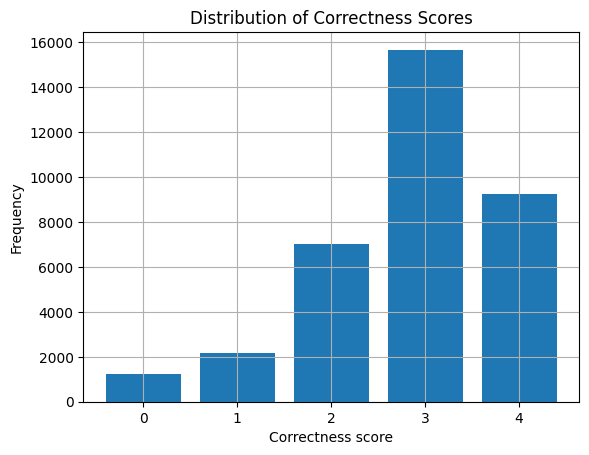

In [36]:
# Value counts (distribution of correctness scores)
print(df["correctness"].value_counts(normalize=True).sort_index())

# Histogram
import matplotlib.pyplot as plt
df["correctness"].hist(bins=[-0.5,0.5,1.5,2.5,3.5,4.5], rwidth=0.8)
plt.xlabel("Correctness score")
plt.ylabel("Frequency")
plt.title("Distribution of Correctness Scores")
plt.show()


In [37]:
prop_high = (df["correctness"] >= 3).mean()
print("Proportion correctness ≥3:", prop_high)


Proportion correctness ≥3: 0.7059805836234468


=== Overall metric means (raw, z, min–max) and share of totals ===
             raw_mean  z_mean  mm_mean  raw_share_of_total  mm_share_of_total
correctness     2.838     0.0    0.710               0.238              0.238
helpfulness     2.787    -0.0    0.697               0.234              0.234
coherence       3.300    -0.0    0.825               0.277              0.277
complexity      1.444     0.0    0.361               0.121              0.121
verbosity       1.535     0.0    0.384               0.129              0.129

=== Totals (raw vs z vs min–max) — descriptive stats ===
       total_raw    total_z   total_mm
count  35331.000  35331.000  35331.000
mean      11.904      0.000      2.976
std        3.273      3.607      0.818
min        0.000    -13.390      0.000
25%       10.000     -2.017      2.500
50%       12.000      0.174      3.000
75%       14.000      2.383      3.500
max       20.000      9.075      5.000

=== Per-correctness average (RAW) ===
             corr

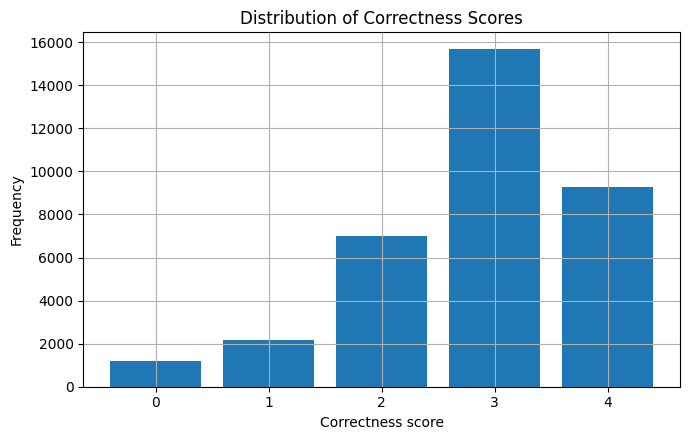

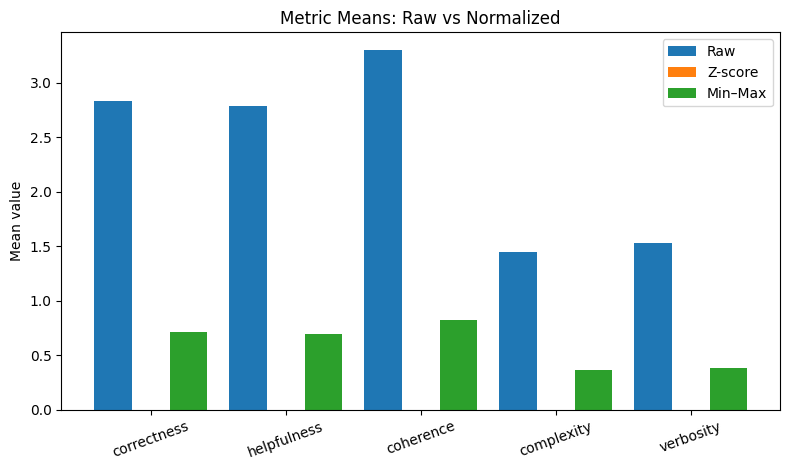

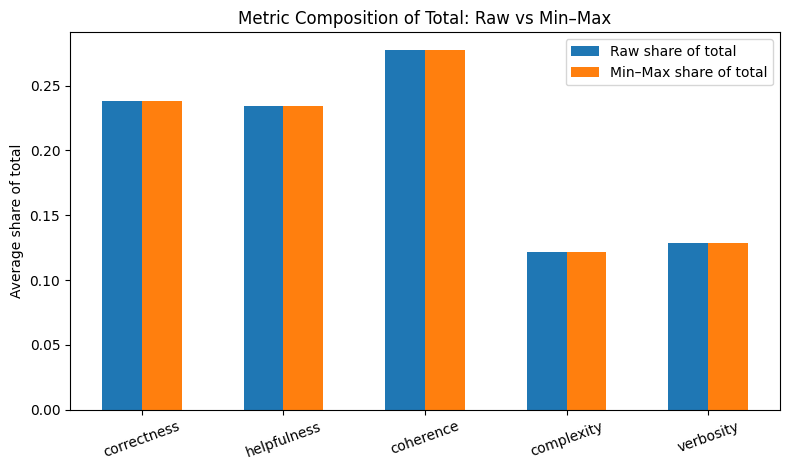

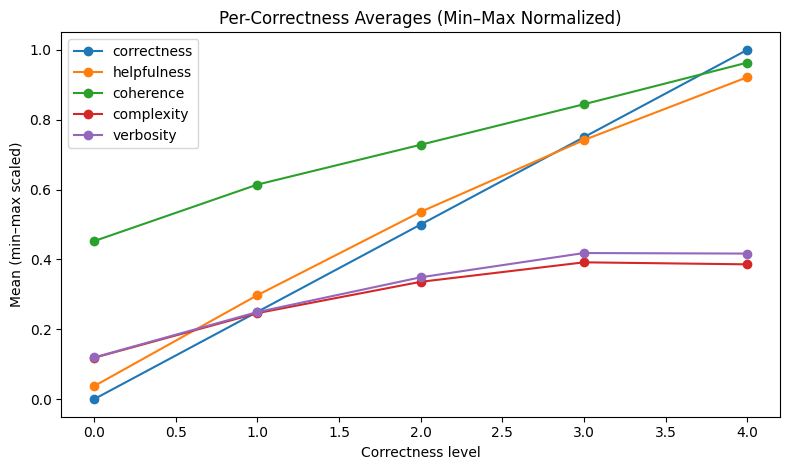

In [40]:
# ==== One-and-done normalization + summaries + plots ====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# -----------------------------
# 0) Config
# -----------------------------
metrics = ["correctness","helpfulness","coherence","complexity","verbosity"]
assert set(metrics).issubset(df.columns), "df must contain the 5 metric columns."

# Work on a copy
d = df.copy()

# -----------------------------
# 1) Raw totals
# -----------------------------
d["total_raw"] = d[metrics].sum(axis=1)

# -----------------------------
# 2) Normalizations
# -----------------------------
# Z-score
z_scaler = StandardScaler()
d[[f"{m}_z" for m in metrics]] = z_scaler.fit_transform(d[metrics])

# Min–max to [0,1]
mm_scaler = MinMaxScaler()
d[[f"{m}_mm" for m in metrics]] = mm_scaler.fit_transform(d[metrics])

# Normalized totals
d["total_z"]  = d[[f"{m}_z"  for m in metrics]].sum(axis=1)
d["total_mm"] = d[[f"{m}_mm" for m in metrics]].sum(axis=1)

# -----------------------------
# 3) Summary tables
# -----------------------------
# Overall means (raw & normalized)
overall_means = pd.DataFrame({
    "raw_mean": d[metrics].mean(),
    "z_mean":   d[[f"{m}_z" for m in metrics]].mean().values,
    "mm_mean":  d[[f"{m}_mm" for m in metrics]].mean().values
}, index=metrics)

# Share of total (raw): average contribution of each metric to total_raw
# (mean of metric / mean of total) — for quick “composition” intuition
overall_shares_raw = (d[metrics].mean() / d["total_raw"].mean()).rename("raw_share_of_total")

# Same for min–max total
overall_shares_mm = (d[[f"{m}_mm" for m in metrics]].mean().values / d["total_mm"].mean())
overall_shares_mm = pd.Series(overall_shares_mm, index=metrics, name="mm_share_of_total")

# Per-correctness level (0..4): average raw and normalized scores
by_corr = {}
for colset_name, cols in [("raw", metrics),
                          ("z", [f"{m}_z" for m in metrics]),
                          ("mm", [f"{m}_mm" for m in metrics])]:
    tmp = d.groupby("correctness")[cols].mean()
    tmp.columns = [c.replace("_z","").replace("_mm","") for c in tmp.columns]
    by_corr[colset_name] = tmp

# Put useful summaries in variables you can print/display
summary_overall = pd.concat([overall_means, overall_shares_raw, overall_shares_mm], axis=1)
summary_totals  = d[["total_raw","total_z","total_mm"]].describe()

print("=== Overall metric means (raw, z, min–max) and share of totals ===")
print(summary_overall.round(3))
print("\n=== Totals (raw vs z vs min–max) — descriptive stats ===")
print(summary_totals.round(3))

print("\n=== Per-correctness average (RAW) ===")
print(by_corr["raw"].round(3))
print("\n=== Per-correctness average (Z-SCORE) ===")
print(by_corr["z"].round(3))
print("\n=== Per-correctness average (MIN–MAX) ===")
print(by_corr["mm"].round(3))

# -----------------------------
# 4) Plots (matplotlib only)
# -----------------------------
plt.figure(figsize=(7,4.5))
d["correctness"].hist(bins=[-0.5,0.5,1.5,2.5,3.5,4.5], rwidth=0.8)
plt.xlabel("Correctness score")
plt.ylabel("Frequency")
plt.title("Distribution of Correctness Scores")
plt.tight_layout()
plt.show()

# Grouped bar: raw vs normalized (means)
x = np.arange(len(metrics))
width = 0.28
fig, ax = plt.subplots(figsize=(8,4.8))
ax.bar(x - width, overall_means["raw_mean"].values, width, label="Raw")
ax.bar(x,         overall_means["z_mean"].values,   width, label="Z-score")
ax.bar(x + width, overall_means["mm_mean"].values,  width, label="Min–Max")
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=20)
ax.set_ylabel("Mean value")
ax.set_title("Metric Means: Raw vs Normalized")
ax.legend()
plt.tight_layout()
plt.show()

# Composition bars: share of total (raw vs min–max)
fig, ax = plt.subplots(figsize=(8,4.8))
ax.bar(x - width/2, overall_shares_raw.values, width, label="Raw share of total")
ax.bar(x + width/2, overall_shares_mm.values,  width, label="Min–Max share of total")
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=20)
ax.set_ylabel("Average share of total")
ax.set_title("Metric Composition of Total: Raw vs Min–Max")
ax.legend()
plt.tight_layout()
plt.show()

# Per-correctness trend (min–max): each metric mean vs correctness level
fig, ax = plt.subplots(figsize=(8,4.8))
for m in metrics:
    ax.plot(by_corr["mm"].index, by_corr["mm"][m], marker="o", label=m)
ax.set_xlabel("Correctness level")
ax.set_ylabel("Mean (min–max scaled)")
ax.set_title("Per-Correctness Averages (Min–Max Normalized)")
ax.legend()
plt.tight_layout()
plt.show()


In [35]:
import numpy as np
import pandas as pd

# List of metrics
metrics = ["correctness","helpfulness","coherence","complexity","verbosity"]

# Add total (sum of all metrics)
df = df.copy()
df["total_metrics"] = df[metrics].sum(axis=1)

rows = []
for anchor in metrics:
    for level in [3, 4]:
        subset = df[df[anchor] == level]
        if len(subset) == 0:
            avg_vals = {m: np.nan for m in metrics}
            avg_total = np.nan
            n_sub = 0
        else:
            avg_vals = subset[metrics].mean().to_dict()
            avg_total = subset["total_metrics"].mean()
            n_sub = len(subset)
        rows.append({
            "anchor_metric": anchor,
            "anchor_level": level,
            **{f"{m}_avg": avg_vals[m] for m in metrics},
            "total_metrics_avg": avg_total,
            "n_subset": n_sub
        })

results_by_level = pd.DataFrame(rows).sort_values(["anchor_metric","anchor_level"]).reset_index(drop=True)

print("Average scores (and total) when each metric equals 3 or 4:")
print(results_by_level.round(3))


Average scores (and total) when each metric equals 3 or 4:
  anchor_metric  anchor_level  correctness_avg  helpfulness_avg  \
0     coherence             3            2.680            2.628   
1     coherence             4            3.357            3.306   
2    complexity             3            3.277            3.185   
3    complexity             4            3.308            3.143   
4   correctness             3            3.000            2.967   
5   correctness             4            4.000            3.686   
6   helpfulness             3            3.063            3.000   
7   helpfulness             4            3.798            4.000   
8     verbosity             3            3.172            3.122   
9     verbosity             4            3.118            3.094   

   coherence_avg  complexity_avg  verbosity_avg  total_metrics_avg  n_subset  
0          3.000           1.514          1.604             11.426     14930  
1          4.000           1.468          1.5

## Reconstruction of Verbosity and Complexity <a id='Reconstruction of Verbosity and Complexity'></a>

In [31]:
import re
import math
import numpy as np
import pandas as pd

# ---------------------------
# Text utilities (no external deps)
# ---------------------------
_word_re = re.compile(r"[A-Za-z]+(?:'[A-Za-z]+)?")
_sent_re = re.compile(r"[.!?]+")
_vowel_re = re.compile(r"[aeiouyAEIOUY]+")

def safe_len(x): 
    try: return len(x)
    except: return 0

def tokenize_words(s: str):
    if not isinstance(s, str): return []
    return _word_re.findall(s)

def split_sentences(s: str):
    if not isinstance(s, str): return []
    # naive sentence split on punctuation
    parts = _sent_re.split(s)
    # keep non-empty trimmed sentences
    return [p.strip() for p in parts if p.strip()]

def count_syllables(word: str):
    w = word.lower()
    # strip trailing 'e'
    w = re.sub(r'e\b', '', w)
    # count vowel groups
    groups = _vowel_re.findall(w)
    syl = max(1, len(groups))
    return syl

def text_stats(s: str):
    """Compute primitive stats for a text string."""
    words = tokenize_words(s)
    sents = split_sentences(s)
    n_chars = safe_len(s)
    n_words = len(words)
    n_sents = max(1, len(sents))
    # punctuation density
    punct_count = len(re.findall(r"[^\w\s]", s or ""))
    # long words (>=7 letters)
    long_words = sum(1 for w in words if len(w) >= 7)
    # syllables
    syllables = sum(count_syllables(w) for w in words) if n_words > 0 else 0
    # complex words for Gunning Fog (>=3 syllables, excluding proper nouns heuristic skipped)
    complex_words = sum(1 for w in words if count_syllables(w) >= 3)
    # lexical diversity
    vocab = len(set(w.lower() for w in words))
    ttr = (vocab / n_words) if n_words > 0 else 0.0
    # Herdan's C (log V / log N)
    herdan_c = (math.log(max(1, vocab)) / math.log(max(2, n_words))) if n_words > 1 else 0.0

    avg_sent_len = n_words / n_sents
    avg_word_len = (sum(len(w) for w in words) / n_words) if n_words else 0.0
    syll_per_word = (syllables / n_words) if n_words else 0.0
    long_word_ratio = (long_words / n_words) if n_words else 0.0
    punct_ratio = (punct_count / max(1, n_chars))

    # Flesch Reading Ease (higher = easier)
    # RE = 206.835 - 1.015*(W/S) - 84.6*(syll/W)
    flesch_re = 206.835 - 1.015*avg_sent_len - 84.6*syll_per_word if n_words else 0.0

    # Flesch-Kincaid Grade (higher = more complex)
    # FK = 0.39*(W/S) + 11.8*(syll/W) - 15.59
    fk_grade = 0.39*avg_sent_len + 11.8*syll_per_word - 15.59 if n_words else 0.0

    # Gunning Fog Index (approx)
    # Fog = 0.4 * ( (W/S) + 100*(complex_words/W) )
    fog = 0.4 * (avg_sent_len + 100.0*(complex_words / n_words)) if n_words else 0.0

    return {
        "char_count": n_chars,
        "word_count": n_words,
        "sent_count": n_sents,
        "avg_sent_len": avg_sent_len,
        "avg_word_len": avg_word_len,
        "syll_per_word": syll_per_word,
        "long_word_ratio": long_word_ratio,
        "punct_ratio": punct_ratio,
        "flesch_re": flesch_re,   # ease (invert for complexity)
        "fk_grade": fk_grade,     # complexity
        "fog_index": fog,         # complexity
        "ttr": ttr,               # lexical diversity
        "herdan_c": herdan_c      # lexical diversity (length-robust)
    }

def compute_text_features(frame: pd.DataFrame, text_col: str, prefix: str):
    """Compute features from a text column; returns a new DataFrame with prefixed columns."""
    feats = []
    for s in frame[text_col].astype(str).fillna(""):
        feats.append(text_stats(s))
    F = pd.DataFrame(feats)
    F.columns = [f"{prefix}_{c}" for c in F.columns]
    return pd.concat([frame.reset_index(drop=True), F.reset_index(drop=True)], axis=1)

# ---------------------------
# Apply to your data (response text is typical for annotation)
# ---------------------------
# Ensure your df has a 'response' column.
df = df.copy()

df = compute_text_features(df, text_col="response", prefix="resp")
# (Optional) also compute for prompts if useful:
# df = compute_text_features(df, text_col="prompt", prefix="pr")

# ---------------------------
# Build alternative metrics
# ---------------------------
def zscore(s):
    s = pd.to_numeric(s, errors="coerce")
    return (s - s.mean()) / (s.std(ddof=0) + 1e-9)

# Verbosity_alt: combine multiple verbosity proxies
# - log word_count (stabilizes scale)
# - avg_sent_len (words per sentence)
# - char_count per word (avg_word_len)
# - punct_ratio (more punctuation generally correlates with longer/formal text)
df["verbosity_alt"] = (
    zscore(np.log1p(df["resp_word_count"])) +
    zscore(df["resp_avg_sent_len"]) +
    zscore(df["resp_avg_word_len"]) +
    zscore(df["resp_punct_ratio"])
) / 4.0

# Complexity_alt: combine readability + lexical diversity proxies
# - fk_grade, fog_index (higher = more complex)
# - invert flesch_re (lower ease => higher complexity)
# - syll_per_word, long_word_ratio
# - Herdan's C (vocab growth)
df["complexity_alt"] = (
    zscore(df["resp_fk_grade"]) +
    zscore(df["resp_fog_index"]) +
    zscore(-df["resp_flesch_re"]) +
    zscore(df["resp_syll_per_word"]) +
    zscore(df["resp_long_word_ratio"]) +
    zscore(df["resp_herdan_c"])
) / 6.0

# ---------------------------
# Quick sanity checks vs. existing labels
# ---------------------------
metrics_existing = ["helpfulness","correctness","coherence","complexity","verbosity"]
metrics_new      = ["complexity_alt","verbosity_alt"]

available = [m for m in metrics_existing if m in df.columns]
corrs = df[available + metrics_new].corr()

print("Correlation matrix (existing labels + new alt metrics):")
print(corrs.loc[metrics_new, available].round(3))

# If you want to REPLACE label columns for modeling:
# df["verbosity"] = df["verbosity_alt"]
# df["complexity"] = df["complexity_alt"]


Correlation matrix (existing labels + new alt metrics):
                helpfulness  correctness  coherence  complexity  verbosity
complexity_alt        0.159        0.156      0.125       0.133      0.064
verbosity_alt         0.171        0.163      0.086       0.353      0.389


In [ ]:
import numpy as np
import pandas as pd

# 0) Define metrics and a total score across ALL five
metrics = ["correctness","helpfulness","coherence","complexity","verbosity"]
df = df.copy()
df["total_metrics"] = df[metrics].sum(axis=1)

# 1) Core computation
rows = []          # per (anchor, level, other_metric) proportions table
sums_rows = []     # per (anchor, level) total sums table

for anchor in metrics:
    others = [m for m in metrics if m != anchor]
    for level in [3, 4]:
        sub = df[df[anchor] == level].copy()
        n = len(sub)
        if n == 0:
            # Still record the row to keep table shape consistent
            sums_rows.append({
                "anchor_metric": anchor,
                "anchor_level": level,
                "n_subset": 0,
                "sum_total_all": 0.0,
                "n_all_others_high": 0,
                "sum_total_all_others_high": 0.0
            })
            for om in others:
                rows.append({
                    "anchor_metric": anchor,
                    "anchor_level": level,
                    "other_metric": om,
                    "prop_other_high_(>=3)": np.nan,
                    "count_other_high_(>=3)": 0
                })
            continue

        # proportions/counts for each OTHER metric being high (>=3)
        for om in others:
            prop = (sub[om] >= 3).mean()
            cnt  = int((sub[om] >= 3).sum())
            rows.append({
                "anchor_metric": anchor,
                "anchor_level": level,
                "other_metric": om,
                "prop_other_high_(>=3)": round(prop, 4),
                "count_other_high_(>=3)": cnt
            })

        # rows where ALL other metrics are high (>=3)
        all_others_high_mask = (sub[others] >= 3).all(axis=1)
        n_all_others_high = int(all_others_high_mask.sum())

        # sums of total score:
        sum_total_all = float(sub["total_metrics"].sum())
        sum_total_all_others_high = float(sub.loc[all_others_high_mask, "total_metrics"].sum())

        sums_rows.append({
            "anchor_metric": anchor,
            "anchor_level": level,
            "n_subset": n,
            "sum_total_all": round(sum_total_all, 3),
            "n_all_others_high": n_all_others_high,
            "sum_total_all_others_high": round(sum_total_all_others_high, 3)
        })

# 2) Assemble results
proportions_table = pd.DataFrame(rows).sort_values(
    ["anchor_metric", "anchor_level", "other_metric"]
).reset_index(drop=True)

totals_table = pd.DataFrame(sums_rows).sort_values(
    ["anchor_metric", "anchor_level"]
).reset_index(drop=True)

print("=== Proportion of OTHER metrics being high (>=3) when ANCHOR metric is 3 or 4 ===")
display(proportions_table)

print("\n=== Totals by anchor metric & level (3/4) ===")
print("Includes: subset size, sum of total score over subset, count where ALL other metrics are high, and sum of total score restricted to those rows.")
display(totals_table)


Correlation matrix: alt metrics vs existing labels
                helpfulness  correctness  coherence  complexity  verbosity  \
helpfulness           1.000        0.852      0.634       0.235      0.257   
correctness           0.852        1.000      0.625       0.247      0.256   
coherence             0.634        0.625      1.000       0.125      0.142   
complexity            0.235        0.247      0.125       1.000      0.631   
verbosity             0.257        0.256      0.142       0.631      1.000   
complexity_alt        0.159        0.156      0.125       0.133      0.064   
verbosity_alt         0.171        0.163      0.086       0.353      0.389   

                complexity_alt  verbosity_alt  
helpfulness              0.159          0.171  
correctness              0.156          0.163  
coherence                0.125          0.086  
complexity               0.133          0.353  
verbosity                0.064          0.389  
complexity_alt           1.000      

In [34]:
import numpy as np
import pandas as pd

# Define your five metrics (columns should exist in df)
metrics = ["correctness","helpfulness","coherence","complexity","verbosity"]

# Add a total score = sum of all five metrics
df = df.copy()
df["total_score"] = df[metrics].sum(axis=1)

rows = []
for anchor in metrics:
    for level in [3, 4]:
        sub = df[df[anchor] == level]
        # If there are no rows for this (anchor, level), still record NaNs
        if len(sub) == 0:
            avg_vals = {m: np.nan for m in metrics}
            avg_total = np.nan
            n_sub = 0
        else:
            avg_vals = sub[metrics].mean().to_dict()
            avg_total = sub["total_score"].mean()
            n_sub = len(sub)
        rows.append({
            "anchor_metric": anchor,
            "anchor_level": level,
            **{f"{m}_avg": avg_vals[m] for m in metrics},
            "total_score_avg": avg_total,
            "n_subset": n_sub
        })

summary_table = pd.DataFrame(rows).sort_values(["anchor_metric","anchor_level"]).reset_index(drop=True)

# Pretty rounding for display
print("Average scores when each anchor metric equals 3 or 4 (includes total_score = sum of all five):")
display(summary_table.round(3))


Average scores when each anchor metric equals 3 or 4 (includes total_score = sum of all five):


,anchor_metric,anchor_level,correctness_avg,helpfulness_avg,coherence_avg,complexity_avg,verbosity_avg,total_score_avg,n_subset
0,coherence,3,2.680,2.628,3.000,1.514,1.604,11.426,14930
1,coherence,4,3.357,3.306,4.000,1.468,1.580,13.712,16054
2,complexity,3,3.277,3.185,3.484,3.000,2.521,15.468,2823
3,complexity,4,3.308,3.143,3.571,4.000,2.654,16.677,133
4,correctness,3,3.000,2.967,3.377,1.567,1.674,12.585,15674
5,correctness,4,4.000,3.686,3.853,1.544,1.667,14.752,9269
6,helpfulness,3,3.063,3.000,3.410,1.573,1.678,12.724,16452
7,helpfulness,4,3.798,4.000,3.881,1.520,1.667,14.866,8051
8,verbosity,3,3.172,3.122,3.463,2.158,3.000,14.915,4696
9,verbosity,4,3.118,3.094,3.510,2.391,4.000,16.113,363


In [48]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# ---------- helper: version-safe RMSE ----------
def rmse(y_true, y_pred):
    try:
        return mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:
        return np.sqrt(mean_squared_error(y_true, y_pred))

# ---------- ensure base targets/features exist ----------
metrics_orig = ["correctness","helpfulness","coherence","complexity","verbosity"]
assert set(metrics_orig).issubset(df.columns), "df must contain correctness/helpfulness/coherence/complexity/verbosity."

df = df.copy()
df["total_score"] = df[metrics_orig].sum(axis=1)

# Safe prompt/response ratio (if missing)
def safe_len_series(s): return s.fillna("").astype(str).str.len()
if "prompt" in df.columns and "response" in df.columns:
    prompt_len = safe_len_series(df["prompt"])
    response_len = safe_len_series(df["response"])
else:
    prompt_len = pd.Series(0, index=df.index)
    response_len = pd.Series(1, index=df.index)
pr_ratio = (prompt_len.replace(0, np.nan) / response_len.replace(0, np.nan)).replace([np.inf,-np.inf], np.nan).fillna(0.0)
df["pr_ratio"] = pr_ratio

# ---------- candidate single features (aiming for 8 total) ----------
candidates = ["correctness","helpfulness","coherence","complexity","verbosity","pr_ratio"]
if "complexity_alt" in df.columns: candidates.append("complexity_alt")
if "verbosity_alt" in df.columns:  candidates.append("verbosity_alt")

# If fewer than 8 available, just proceed with what's present
print(f"Single-feature models to run: {candidates} (total={len(candidates)})")

# ---------- fit one-feature models ----------
rows = []
details = {}

for feat in candidates:
    X = df[[feat]]
    y = df["total_score"]

    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.25, random_state=42)
    pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("reg", LinearRegression())
    ])
    pipe.fit(X_tr, y_tr)
    y_hat = pipe.predict(X_te)

    res = {
        "Feature": feat,
        "R2": r2_score(y_te, y_hat),
        "RMSE": rmse(y_te, y_hat),
        "Coef": float(pipe.named_steps["reg"].coef_[0]),
        "Intercept": float(pipe.named_steps["reg"].intercept_)
    }
    rows.append(res)
    details[feat] = pipe

# ---------- summary table ----------
summary = pd.DataFrame(rows).sort_values(["R2","RMSE"], ascending=[False, True]).reset_index(drop=True)
print("\n=== One-feature regressions predicting total_score ===")
print(summary.round(4))


Single-feature models to run: ['correctness', 'helpfulness', 'coherence', 'complexity', 'verbosity', 'pr_ratio', 'complexity_alt', 'verbosity_alt'] (total=8)

=== One-feature regressions predicting total_score ===
          Feature      R2    RMSE    Coef  Intercept
0     correctness  0.7020  1.7714  2.7739     4.0194
1     helpfulness  0.6999  1.7776  2.8120     4.0507
2       coherence  0.4728  2.3561  2.9209     2.2524
3       verbosity  0.3932  2.5276  2.2315     8.4795
4      complexity  0.3533  2.6096  2.4302     8.3955
5   verbosity_alt  0.0984  3.0812  2.3105    11.8934
6  complexity_alt  0.0298  3.1962  0.7760    11.8901
7        pr_ratio  0.0217  3.2095 -0.0030    12.0483



## Modeling & Metrics <a id='Modeling'></a>


In [71]:
# 1. Compute variance of each metric
var_share = df[base_metrics].var() / df[base_metrics].var().sum()

# 2. Partial R² for all five metrics
results = []
for m in base_metrics:
    r2_full, r2_reduced, part = partial_r2("total_score", base_metrics, m)
    results.append({
        "Metric": m,
        "R2_full": r2_full,
        "R2_without": r2_reduced,
        "Partial_R2": part,
        "Variance": df[m].var(),
        "Var_Share": var_share[m],
        "Weighted_Importance": part / var_share[m] if var_share[m] > 0 else np.nan
    })

results_df = pd.DataFrame(results).sort_values("Partial_R2", ascending=False)
print("=== Partial R² and Distribution-Weighted Importance ===")
print(results_df.round(3))


=== Partial R² and Distribution-Weighted Importance ===
        Metric  R2_full  R2_without  Partial_R2  Variance  Var_Share  \
4    verbosity      1.0       0.951       0.049     0.865      0.212   
3   complexity      1.0       0.961       0.039     0.676      0.166   
2    coherence      1.0       0.969       0.031     0.593      0.145   
0  correctness      1.0       0.976       0.024     0.989      0.242   
1  helpfulness      1.0       0.977       0.023     0.961      0.235   

   Weighted_Importance  
4                0.233  
3                0.235  
2                0.217  
0                0.100  
1                0.098  


In [ ]:
# 1. Compute variance of each metric
var_share = df[base_metrics].var() / df[base_metrics].var().sum()

# 2. Partial R² for all five metrics
results = []
for m in base_metrics:
    r2_full, r2_reduced, part = partial_r2("total_score", base_metrics, m)
    results.append({
        "Metric": m,
        "R2_full": r2_full,
        "R2_without": r2_reduced,
        "Partial_R2": part,
        "Variance": df[m].var(),
        "Var_Share": var_share[m],
        "Weighted_Importance": part / var_share[m] if var_share[m] > 0 else np.nan
    })

results_df = pd.DataFrame(results).sort_values("Partial_R2", ascending=False)
print("=== Partial R² and Distribution-Weighted Importance ===")
print(results_df.round(3))


In [15]:

def prepare_xy(frame: pd.DataFrame):
    # Binary label: helpfulness ≥ 3
    y = (frame["helpfulness"] >= 3).astype(int)
    X = frame[["correctness","coherence","complexity","verbosity"]].copy()
    return X, y

def fit_evaluate(X, y, title="LogReg (all features)"):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_SEED, stratify=y)
    pipe = Pipeline([("scaler", StandardScaler()), ("clf", LogisticRegression(max_iter=200, random_state=RANDOM_SEED))])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_prob = pipe.predict_proba(X_test)[:,1]
    
    prec, rec, f1, support = precision_recall_fscore_support(y_test, y_pred, average="binary", zero_division=0)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    auc = roc_auc_score(y_test, y_prob)
    
    print(f"=== {title} ===")
    print("Precision:", round(prec,3), "Recall:", round(rec,3), "F1:", round(f1,3), "ROC-AUC:", round(auc,3))
    print("Confusion Matrix:\n", cm)
    print(f"TP rate: {tp/(tp+fn+1e-9):.3f} | FP rate: {fp/(fp+tn+1e-9):.3f}")
    return {"model": pipe, "y_test": y_test, "y_pred": y_pred, "y_prob": y_prob, "cm": cm, "auc": auc, "f1": f1}

if 'df' in globals():
    X_all, y = prepare_xy(df)
    res_all = fit_evaluate(X_all, y, title="LogReg (correctness, coherence, complexity, verbosity)")
    
    # Ablation: remove verbosity to test bias contribution
    X_noverb = df[["correctness","coherence","complexity"]]
    res_noverb = fit_evaluate(X_noverb, y, title="LogReg (no verbosity)")
else:
    print("Load data first.")


=== LogReg (correctness, coherence, complexity, verbosity) ===
Precision: 0.911 Recall: 0.934 F1: 0.922 ROC-AUC: 0.935
Confusion Matrix:
 [[2148  559]
 [ 404 5722]]
TP rate: 0.934 | FP rate: 0.207
=== LogReg (no verbosity) ===
Precision: 0.913 Recall: 0.932 F1: 0.923 ROC-AUC: 0.933
Confusion Matrix:
 [[2163  544]
 [ 414 5712]]
TP rate: 0.932 | FP rate: 0.201


In [62]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error

# ---------- helpers ----------
def rmse(y_true, y_pred):
    try:
        return mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:
        return np.sqrt(mean_squared_error(y_true, y_pred))

def to_series1d(x, index=None):
    """Coerce x (Series/ndarray/DataFrame/list) to a 1-D Series aligned to index."""
    if isinstance(x, pd.Series):
        return x
    if isinstance(x, pd.DataFrame):
        # take the first column if duplicated names produced a 2D frame
        return x.iloc[:, 0]
    arr = np.asarray(x)
    if arr.ndim > 1:
        arr = arr[:, 0]
    return pd.Series(arr, index=index)

def zscore(x):
    s = to_series1d(x)
    s = pd.to_numeric(s, errors="coerce")
    return (s - s.mean()) / (s.std(ddof=0) + 1e-9)

# ---------- 1) clean up any old resp_* columns ----------
resp_cols = [c for c in df.columns if c.startswith("resp_")]
if resp_cols:
    df = df.drop(columns=resp_cols)

# ---------- 2) recompute text features cleanly ----------
# assumes your compute_text_features(text_col="response", prefix="resp") is already defined earlier
df = compute_text_features(df, text_col="response", prefix="resp")

# (defensive) collapse any duplicate column names by keeping the first occurrence
# e.g., if running twice somehow still duplicated names
if df.columns.duplicated().any():
    df = df.loc[:, ~df.columns.duplicated(keep="first")]

# ---------- 3) compute alt metrics with strict 1-D coercion ----------
resp_wc         = to_series1d(df["resp_word_count"], index=df.index)
resp_avg_sent   = to_series1d(df["resp_avg_sent_len"], index=df.index)
resp_avg_word   = to_series1d(df["resp_avg_word_len"], index=df.index)
resp_punct      = to_series1d(df["resp_punct_ratio"], index=df.index)

resp_fk         = to_series1d(df["resp_fk_grade"], index=df.index)
resp_fog        = to_series1d(df["resp_fog_index"], index=df.index)
resp_flesch     = to_series1d(df["resp_flesch_re"], index=df.index)
resp_syll       = to_series1d(df["resp_syll_per_word"], index=df.index)
resp_longratio  = to_series1d(df["resp_long_word_ratio"], index=df.index)
resp_herdan     = to_series1d(df["resp_herdan_c"], index=df.index)

df["verbosity_alt"] = (
    zscore(np.log1p(resp_wc)) +
    zscore(resp_avg_sent) +
    zscore(resp_avg_word) +
    zscore(resp_punct)
) / 4.0

df["complexity_alt"] = (
    zscore(resp_fk) +
    zscore(resp_fog) +
    zscore(-resp_flesch) +
    zscore(resp_syll) +
    zscore(resp_longratio) +
    zscore(resp_herdan)
) / 6.0

# ---------- 4) make sure target & structural features exist ----------
base_vars = ["correctness","helpfulness","coherence","complexity","verbosity"]
assert set(base_vars).issubset(df.columns), "Missing some of the 5 annotation columns."

df["total_score"] = df[base_vars].sum(axis=1)

# pr_ratio (safe)
def safe_len_series(s): return s.fillna("").astype(str).str.len()
if "prompt" in df.columns and "response" in df.columns:
    prompt_len = safe_len_series(df["prompt"])
    resp_len   = safe_len_series(df["response"])
else:
    prompt_len = pd.Series(0, index=df.index)
    resp_len   = pd.Series(1, index=df.index)

df["pr_ratio"] = (prompt_len.replace(0, np.nan) / resp_len.replace(0, np.nan)).replace([np.inf,-np.inf], np.nan).fillna(0.0)

# ---------- 5) Ridge regression on base + engineered ----------
engineered_vars = [
    "complexity_alt","verbosity_alt","pr_ratio",
    "resp_word_count","resp_avg_sent_len","resp_avg_word_len",
    "resp_syll_per_word","resp_long_word_ratio","resp_punct_ratio",
    "resp_flesch_re","resp_fk_grade","resp_fog_index","resp_smog_index","resp_dale_chall",
    "resp_ttr","resp_herdan_c","resp_polarity","resp_subjectivity"
]
engineered_vars = [c for c in engineered_vars if c in df.columns and pd.api.types.is_numeric_dtype(df[c])]

all_vars = base_vars + engineered_vars
X = df[all_vars]
y = df["total_score"]

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.25, random_state=42)

alphas = [0.01, 0.1, 1.0, 10.0, 100.0]
ridge_results = []

for a in alphas:
    pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("ridge", Ridge(alpha=a, random_state=42))
    ])
    pipe.fit(X_tr, y_tr)
    y_hat = pipe.predict(X_te)

    ridge = pipe.named_steps["ridge"]
    ridge_results.append({
        "alpha": a,
        "R2": r2_score(y_te, y_hat),
        "RMSE": rmse(y_te, y_hat),
        "Coefficients": dict(zip(all_vars, ridge.coef_))
    })

# summary + top coefficients
summary = pd.DataFrame([{"alpha": r["alpha"], "R2": r["R2"], "RMSE": r["RMSE"]} for r in ridge_results]) \
            .sort_values("R2", ascending=False).reset_index(drop=True)
print("=== Ridge Regression (clean recompute; standardized) ===")
print(summary.round(4))

best = max(ridge_results, key=lambda r: r["R2"])
print(f"\n--- Top coefficients at alpha={best['alpha']} (standardized feature space) ---")
top = sorted(best["Coefficients"].items(), key=lambda kv: abs(kv[1]), reverse=True)[:15]
for k,v in top:
    print(f"{k:24s}  {v:+.4f}")


=== Ridge Regression (clean recompute; standardized) ===
    alpha   R2    RMSE
0    0.01  1.0  0.0000
1    0.10  1.0  0.0000
2    1.00  1.0  0.0001
3   10.00  1.0  0.0006
4  100.00  1.0  0.0057

--- Top coefficients at alpha=0.01 (standardized feature space) ---
correctness               +0.9962
helpfulness               +0.9812
verbosity                 +0.9294
complexity                +0.8222
coherence                 +0.7718
verbosity_alt             +0.0000
resp_punct_ratio          -0.0000
resp_avg_sent_len         -0.0000
resp_avg_word_len         -0.0000
resp_flesch_re            -0.0000
resp_fk_grade             -0.0000
resp_word_count           +0.0000
resp_syll_per_word        -0.0000
resp_fog_index            -0.0000
pr_ratio                  +0.0000


In [73]:
import numpy as np
import pandas as pd
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

metrics = ["correctness","helpfulness","coherence","complexity","verbosity"]
df = df.copy()
df["total_score"] = df[metrics].sum(axis=1)

# ------------------------------
# Helper: Ridge regression R²
# ------------------------------
def ridge_r2(X, y, alphas=(0.01,0.1,1,10,100)):
    pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("ridge", RidgeCV(alphas=alphas))
    ])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    return r2_score(y_test, y_pred), pipe.named_steps["ridge"].alpha_

# ------------------------------
# 1. Baseline (all except correctness)
# ------------------------------
X_base = df[[m for m in metrics if m != "correctness"]]
y = df["total_score"]
r2_base, alpha_base = ridge_r2(X_base, y)

# ------------------------------
# 2. With correctness added
# ------------------------------
X_plus = df[metrics]  # includes correctness
r2_plus, alpha_plus = ridge_r2(X_plus, y)

# ------------------------------
# 3. Improvement scaled
# ------------------------------
improvement = r2_plus - r2_base
relative_gain = improvement / (1 - r2_base)

print("=== Effect of Adding Correctness ===")
print(f"Baseline R² (no correctness): {r2_base:.3f} (alpha={alpha_base})")
print(f"With correctness:             {r2_plus:.3f} (alpha={alpha_plus})")
print(f"Absolute improvement:         {improvement:.3f}")
print(f"Relative gain vs unexplained: {relative_gain*100:.1f}%")


=== Effect of Adding Correctness ===
Baseline R² (no correctness): 0.976 (alpha=0.1)
With correctness:             1.000 (alpha=0.01)
Absolute improvement:         0.024
Relative gain vs unexplained: 100.0%


In [74]:
from itertools import combinations

def ridge_r2(X, y, alphas=(0.01,0.1,1,10,100)):
    pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("ridge", RidgeCV(alphas=alphas))
    ])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    return r2_score(y_test, y_pred)

metrics = ["correctness","helpfulness","coherence","complexity","verbosity"]
y = df["total_score"]

results = []

for anchor in metrics:
    # 1) Model with anchor only
    r2_anchor = ridge_r2(df[[anchor]], y)

    # 2) Anchor + correctness (if not already correctness)
    if anchor != "correctness":
        r2_plus_corr = ridge_r2(df[[anchor,"correctness"]], y)
        delta_corr = r2_plus_corr - r2_anchor
        results.append({
            "Anchor": anchor,
            "Added": "correctness",
            "R2_anchor": r2_anchor,
            "R2_with": r2_plus_corr,
            "Delta": delta_corr
        })

    # 3) Anchor + other (non-correctness, non-anchor)
    others = [m for m in metrics if m not in [anchor,"correctness"]]
    for other in others:
        r2_plus_other = ridge_r2(df[[anchor, other]], y)
        delta_other = r2_plus_other - r2_anchor
        results.append({
            "Anchor": anchor,
            "Added": other,
            "R2_anchor": r2_anchor,
            "R2_with": r2_plus_other,
            "Delta": delta_other
        })

results_df = pd.DataFrame(results)
print("=== Marginal benefit of adding variables ===")
print(results_df.sort_values(["Anchor","Delta"], ascending=[True,False]).round(3))


=== Marginal benefit of adding variables ===
         Anchor        Added  R2_anchor  R2_with  Delta
11    coherence    verbosity      0.473    0.760  0.288
8     coherence  correctness      0.473    0.746  0.274
10    coherence   complexity      0.473    0.742  0.269
9     coherence  helpfulness      0.473    0.739  0.267
13   complexity  helpfulness      0.353    0.880  0.527
12   complexity  correctness      0.353    0.871  0.518
14   complexity    coherence      0.353    0.742  0.389
15   complexity    verbosity      0.353    0.462  0.108
3   correctness    verbosity      0.702    0.890  0.188
2   correctness   complexity      0.702    0.871  0.169
0   correctness  helpfulness      0.702    0.757  0.055
1   correctness    coherence      0.702    0.746  0.044
7   helpfulness    verbosity      0.700    0.888  0.188
6   helpfulness   complexity      0.700    0.880  0.180
4   helpfulness  correctness      0.700    0.757  0.057
5   helpfulness    coherence      0.700    0.739  0.040
16 


=== Average ΔR² when each variable is added (stand-alone across anchors) ===
                     Added  Delta_R2
5  correctness+helpfulness    0.4685
6    correctness+verbosity    0.4189
4   correctness+complexity    0.4001
3    correctness+coherence    0.3938
2              correctness    0.3348
7              helpfulness    0.3338
0                coherence    0.2067
8                verbosity    0.1907
1               complexity    0.1726


C:\Users\ethan\AppData\Local\Temp\ipykernel_20640\3915856137.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_gain, x="Added", y="Delta_R2", palette="viridis")


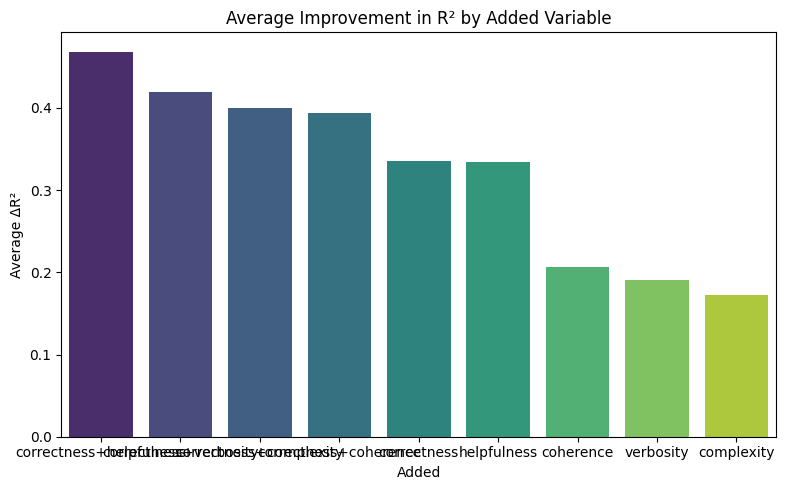

In [77]:
# -----------------------------------
# Average marginal benefit per added variable
# -----------------------------------
avg_gain = (
    results_df.groupby("Added")["Delta_R2"]
    .mean()
    .reset_index()
    .sort_values("Delta_R2", ascending=False)
)

print("\n=== Average ΔR² when each variable is added (stand-alone across anchors) ===")
print(avg_gain.round(4))

# Bar chart
plt.figure(figsize=(8,5))
sns.barplot(data=avg_gain, x="Added", y="Delta_R2", palette="viridis")
plt.ylabel("Average ΔR²")
plt.title("Average Improvement in R² by Added Variable")
plt.tight_layout()
plt.show()


      Anchor                    Spec        R2
0  verbosity               Annotated  0.397555
1  verbosity              Engineered  0.102235
2  verbosity   Annotated+Correctness  0.891837
3  verbosity  Engineered+Correctness  0.741443
4  coherence               Annotated  0.471832
5  coherence              Engineered  0.030513
6  coherence   Annotated+Correctness  0.749766
7  coherence  Engineered+Correctness  0.709001


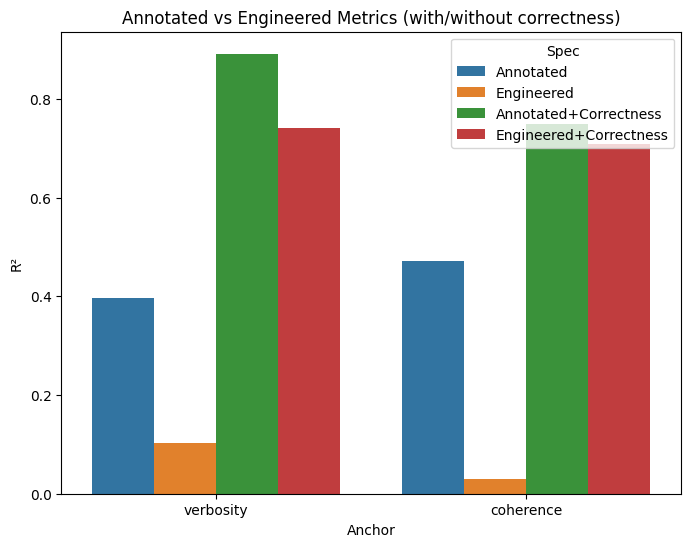

In [78]:
# Define engineered features (assuming already in df: verbosity_alt, complexity_alt, etc.)
# For coherence_alt: replace with your engineered computation
engineered_map = {
    "verbosity": "verbosity_alt",
    "coherence": "complexity_alt"  # replace with coherence_alt once you calculate it
}

anchors = ["verbosity", "coherence"]
results_subst = []

for anchor in anchors:
    alt = engineered_map[anchor]

    # Baseline annotated
    r2_ann = spec_r2(df, [anchor], "total_score", folds)
    # Engineered version
    r2_alt = spec_r2(df, [alt], "total_score", folds)

    # With correctness
    r2_ann_corr = spec_r2(df, [anchor,"correctness"], "total_score", folds)
    r2_alt_corr = spec_r2(df, [alt,"correctness"], "total_score", folds)

    results_subst.append({
        "Anchor": anchor,
        "Spec": "Annotated",
        "R2": r2_ann
    })
    results_subst.append({
        "Anchor": anchor,
        "Spec": "Engineered",
        "R2": r2_alt
    })
    results_subst.append({
        "Anchor": anchor,
        "Spec": "Annotated+Correctness",
        "R2": r2_ann_corr
    })
    results_subst.append({
        "Anchor": anchor,
        "Spec": "Engineered+Correctness",
        "R2": r2_alt_corr
    })

subst_df = pd.DataFrame(results_subst)
print(subst_df)

# Plot comparison
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.barplot(data=subst_df, x="Anchor", y="R2", hue="Spec")
plt.title("Annotated vs Engineered Metrics (with/without correctness)")
plt.ylabel("R²")
plt.show()



=== Annotated vs Engineered (RidgeCV 5-fold) ===
      Anchor                    Spec      R2
0  verbosity               Annotated  0.3976
1  verbosity              Engineered  0.1349
2  verbosity   Annotated+Correctness  0.8918
3  verbosity  Engineered+Correctness  0.7652
4  coherence               Annotated  0.4718
5  coherence              Engineered  0.0633
6  coherence   Annotated+Correctness  0.7498
7  coherence  Engineered+Correctness  0.7198


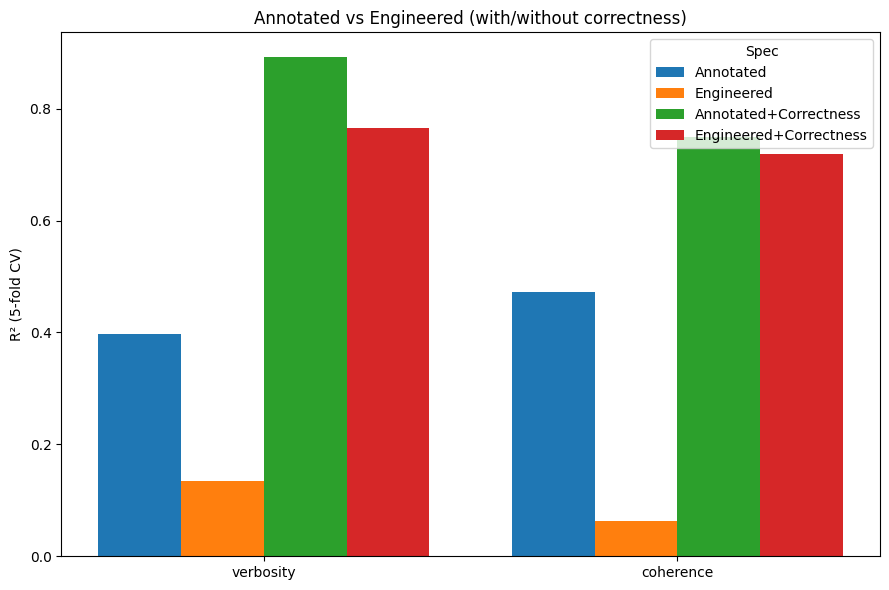


=== Marginal ΔR² when adding correctness (annotated vs engineered) ===
      Anchor                        Spec  Delta_R2
0  verbosity   Annotated -> +Correctness    0.4943
1  verbosity  Engineered -> +Correctness    0.6304
2  coherence   Annotated -> +Correctness    0.2779
3  coherence  Engineered -> +Correctness    0.6564


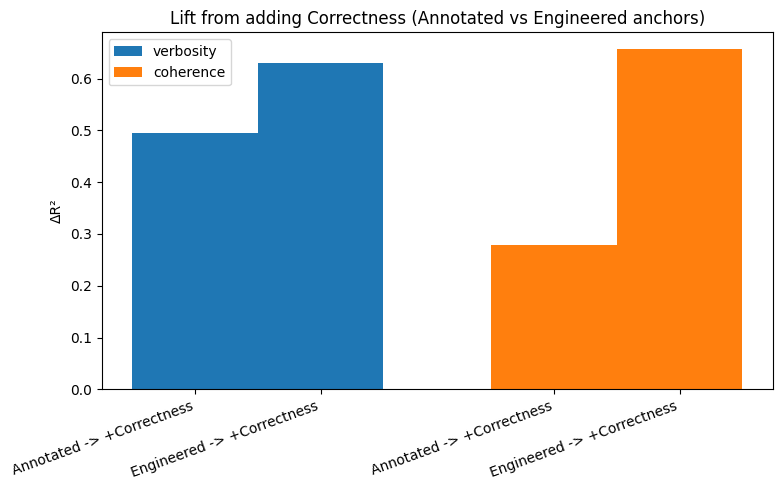

In [85]:
# ===== 0) Imports =====
import re, math, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score

# ===== 1) Load data (FIXED) =====
csv_path = r"C:\Users\ethan\Downloads\classes\ai-alignment\train.csv"  # <- your path
df = pd.read_csv(csv_path)

BASE = ["correctness","helpfulness","coherence","complexity","verbosity"]
assert set(BASE).issubset(df.columns), "CSV must contain the five annotation columns."
df["total_score"] = df[BASE].sum(axis=1)

# ===== 2) Lightweight text utils =====
STOPWORDS = set("""a about above after again against all am an and any are aren't as at be because been before
being below between both but by can't cannot could couldn't did didn't do does doesn't doing don't down during
each few for from further had hadn't has hasn't have haven't having he he'd he'll he's her here here's hers
herself him himself his how how's i i'd i'll i'm i've if in into is isn't it it's its itself let's me more most
mustn't my myself no nor not of off on once only or other ought our ours ourselves out over own same shan't she
she'd she'll she's should shouldn't so some such than that that's the their theirs them themselves then there
there's these they they'd they'll they're they've this those through to too under until up very was wasn't we
we'd we'll we're we've were weren't what what's when when's where where's which while who who's whom why why's
with won't would wouldn't you you'd you'll you're you've your yours yourself yourselves""".split())

CONNECTIVES = set("""however therefore moreover furthermore consequently additionally meanwhile instead
nevertheless nonetheless because since thus hence although though whereas while firstly secondly thirdly finally
in contrast as a result on the other hand for example for instance in particular""".split())

def tokenize_words(text):
    return re.findall(r"[A-Za-z']+", (text or "").lower())

def split_sentences(text):
    sents = re.split(r"[.!?]+", (text or ""))
    return [s.strip() for s in sents if s.strip()]

def count_syllables(word):
    w = word.lower()
    vowels = "aeiouy"
    num, prev = 0, False
    for ch in w:
        is_v = ch in vowels
        if is_v and not prev: num += 1
        prev = is_v
    if w.endswith("e") and num > 1: num -= 1
    return max(1, num) if w else 0

def herdan_c(words):
    n = len(words)
    if n <= 1: return 0.0
    v = len(set(words))
    return math.log(max(1, v)) / math.log(max(2, n))

def resp_features(text):
    s = text if isinstance(text, str) else ""
    words = tokenize_words(s)
    sents = split_sentences(s)
    n_words, n_sents, n_chars = len(words), max(1, len(sents)), len(s)

    punct_count = len(re.findall(r"[^\w\s]", s))
    long_words = sum(1 for w in words if len(w) >= 7)
    syllables = sum(count_syllables(w) for w in words) if n_words else 0
    complex_words = sum(1 for w in words if count_syllables(w) >= 3)

    avg_sent_len = (n_words / n_sents) if n_sents else 0.0
    avg_word_len = (sum(len(w) for w in words) / n_words) if n_words else 0.0
    sent_lens = [len(tokenize_words(t)) for t in sents] if sents else [0]
    sent_len_var = float(np.var(sent_lens)) if sent_lens else 0.0

    stop_ratio = (sum(1 for w in words if w in STOPWORDS) / n_words) if n_words else 0.0
    long_word_ratio = (long_words / n_words) if n_words else 0.0
    punct_ratio = (punct_count / max(1, n_chars))
    ttr = (len(set(words)) / n_words) if n_words else 0.0
    herdan = herdan_c(words)
    repeat_ratio = (pd.Series(words).value_counts().pipe(lambda c: float(c[c>1].sum())) / n_words) if n_words else 0.0
    conn_per_sent = (sum(1 for w in words if w in CONNECTIVES) / n_sents) if n_sents else 0.0

    syll_per_word = (syllables / n_words) if n_words else 0.0
    flesch_re = 206.835 - 1.015*avg_sent_len - 84.6*syll_per_word if n_words else 0.0
    fk_grade  = 0.39*avg_sent_len + 11.8*syll_per_word - 15.59 if n_words else 0.0
    fog_index = 0.4*(avg_sent_len + 100.0*(complex_words / n_words)) if n_words else 0.0
    smog = (1.043*np.sqrt((complex_words*30.0 / n_sents) + 1e-9) + 3.1291) if n_sents else 0.0

    return {
        "resp_word_count": n_words,
        "resp_char_count": n_chars,
        "resp_avg_sent_len": avg_sent_len,
        "resp_avg_word_len": avg_word_len,
        "resp_sent_len_var": sent_len_var,
        "resp_punct_ratio": punct_ratio,
        "resp_stop_ratio": stop_ratio,
        "resp_repeat_ratio": repeat_ratio,
        "resp_long_word_ratio": long_word_ratio,
        "resp_ttr": ttr,
        "resp_herdan_c": herdan,
        "resp_connectives_per_sent": conn_per_sent,
        "resp_flesch_re": flesch_re,
        "resp_fk_grade": fk_grade,
        "resp_fog_index": fog_index,
        "resp_smog_index": smog,
        "resp_syll_per_word": syll_per_word,
    }

feat_df = df["response"].apply(resp_features).pipe(lambda s: pd.DataFrame(list(s.values)))
df = pd.concat([df, feat_df], axis=1)

# ===== 3) Engineered metrics =====
def zscore(s):
    s = pd.to_numeric(s, errors="coerce")
    return (s - s.mean()) / (s.std(ddof=0) + 1e-9)

# Verbosity_alt (length/density/redundancy/filler)
df["verbosity_alt"] = (
    zscore(np.log1p(df["resp_word_count"])) +
    zscore(df["resp_avg_sent_len"]) +
    zscore(df["resp_avg_word_len"]) +
    zscore(df["resp_punct_ratio"]) +
    zscore(df["resp_stop_ratio"]) +
    zscore(df["resp_repeat_ratio"])
) / 6.0

# Coherence_alt (flow/structure/readability/lexical cohesion)
df["coherence_alt"] = (
    zscore(-df["resp_sent_len_var"]) +
    zscore(df["resp_connectives_per_sent"]) +
    zscore(-df["resp_flesch_re"]) +     # harder text often more formal/structured
    zscore(df["resp_fk_grade"]) +
    zscore(df["resp_fog_index"]) +
    zscore(df["resp_smog_index"]) +
    zscore(df["resp_herdan_c"])
) / 7.0

# ===== 4) RidgeCV evaluator =====
def ridge_cv_r2(X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("ridge", RidgeCV(alphas=(0.01,0.1,1.0,10.0,100.0), cv=5))
    ])
    scores = []
    for tr, te in kf.split(X):
        Xtr, Xte = X.iloc[tr], X.iloc[te]
        ytr, yte = y.iloc[tr], y.iloc[te]
        pipe.fit(Xtr, ytr)
        yhat = pipe.predict(Xte)
        scores.append(r2_score(yte, yhat))
    return float(np.mean(scores))

# ===== 5) Annotated vs Engineered (with/without correctness) =====
compare_rows = []
for anchor, alt in [("verbosity","verbosity_alt"), ("coherence","coherence_alt")]:
    r2_ann       = ridge_cv_r2(df[[anchor]], df["total_score"])
    r2_alt       = ridge_cv_r2(df[[alt]], df["total_score"])
    r2_ann_corr  = ridge_cv_r2(df[[anchor,"correctness"]], df["total_score"])
    r2_alt_corr  = ridge_cv_r2(df[[alt,"correctness"]], df["total_score"])
    compare_rows += [
        {"Anchor": anchor, "Spec":"Annotated",              "R2": r2_ann},
        {"Anchor": anchor, "Spec":"Engineered",             "R2": r2_alt},
        {"Anchor": anchor, "Spec":"Annotated+Correctness",  "R2": r2_ann_corr},
        {"Anchor": anchor, "Spec":"Engineered+Correctness", "R2": r2_alt_corr},
    ]

comp_df = pd.DataFrame(compare_rows)
print("\n=== Annotated vs Engineered (RidgeCV 5-fold) ===")
print(comp_df.round(4))

# Plot
anchors = comp_df["Anchor"].unique().tolist()
specs = ["Annotated","Engineered","Annotated+Correctness","Engineered+Correctness"]
plt.figure(figsize=(9,6))
x = np.arange(len(anchors)); width = 0.2
for i, spec in enumerate(specs):
    vals = [comp_df[(comp_df["Anchor"]==a) & (comp_df["Spec"]==spec)]["R2"].values[0] for a in anchors]
    plt.bar(x + (i-1.5)*width, vals, width, label=spec)
plt.xticks(x, anchors)
plt.ylabel("R² (5-fold CV)")
plt.title("Annotated vs Engineered (with/without correctness)")
plt.legend(title="Spec")
plt.tight_layout(); plt.show()

# ===== 6) Marginal benefit experiment for these anchors =====
def nested_ridge_r2(X, y, alphas=(0.01,0.1,1.0,10.0,100.0), outer=5, inner=4):
    kf_outer = KFold(n_splits=outer, shuffle=True, random_state=42)
    scores = []
    for tr, te in kf_outer.split(X):
        Xtr, Xte = X.iloc[tr], X.iloc[te]
        ytr, yte = y.iloc[tr], y.iloc[te]
        pipe = Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
            ("ridge", RidgeCV(alphas=alphas, cv=min(inner, max(2, len(Xtr)-1))))
        ])
        pipe.fit(Xtr, ytr)
        yhat = pipe.predict(Xte)
        scores.append(r2_score(yte, yhat))
    return float(np.mean(scores))

y = df["total_score"]
marginal = []
for anchor, alt in [("verbosity","verbosity_alt"), ("coherence","coherence_alt")]:
    # anchor only vs + correctness
    r2_anchor = nested_ridge_r2(df[[anchor]], y)
    r2_anchor_corr = nested_ridge_r2(df[[anchor,"correctness"]], y)
    # engineered only vs + correctness
    r2_alt = nested_ridge_r2(df[[alt]], y)
    r2_alt_corr = nested_ridge_r2(df[[alt,"correctness"]], y)
    marginal += [
        {"Anchor": anchor, "Spec":"Annotated -> +Correctness", "Delta_R2": r2_anchor_corr - r2_anchor},
        {"Anchor": anchor, "Spec":"Engineered -> +Correctness","Delta_R2": r2_alt_corr - r2_alt},
    ]

marg_df = pd.DataFrame(marginal)
print("\n=== Marginal ΔR² when adding correctness (annotated vs engineered) ===")
print(marg_df.round(4))

# Plot marginal lifts
plt.figure(figsize=(8,5))
cats = marg_df["Spec"].unique().tolist()
x = np.arange(len(anchors)); width = 0.35
# build per-anchor bars in order of cats
vals_a = [marg_df[(marg_df["Anchor"]==anchors[0]) & (marg_df["Spec"]==cats[0])]["Delta_R2"].values[0],
          marg_df[(marg_df["Anchor"]==anchors[0]) & (marg_df["Spec"]==cats[1])]["Delta_R2"].values[0]]
vals_b = [marg_df[(marg_df["Anchor"]==anchors[1]) & (marg_df["Spec"]==cats[0])]["Delta_R2"].values[0],
          marg_df[(marg_df["Anchor"]==anchors[1]) & (marg_df["Spec"]==cats[1])]["Delta_R2"].values[0]]
plt.bar([0,width], vals_a, width=width, label=f"{anchors[0]}")
plt.bar([1+0,1+width], vals_b, width=width, label=f"{anchors[1]}")
plt.xticks([0, width, 1, 1+width], [f"{cats[0]}", f"{cats[1]}", f"{cats[0]}", f"{cats[1]}"], rotation=20, ha="right")
plt.ylabel("ΔR²")
plt.title("Lift from adding Correctness (Annotated vs Engineered anchors)")
plt.legend()
plt.tight_layout(); plt.show()


=== Separate vs Hybrid models (R² on held-out test) ===
      Anchor                  Model      R2
0  verbosity         Annotated only  0.3932
1  verbosity        Engineered only  0.1294
2  verbosity  Hybrid (concatenated)  0.3946
3  verbosity       Hybrid (stacked)  0.3946
4  coherence         Annotated only  0.4728
5  coherence        Engineered only  0.0634
6  coherence  Hybrid (concatenated)  0.5059
7  coherence       Hybrid (stacked)  0.5059


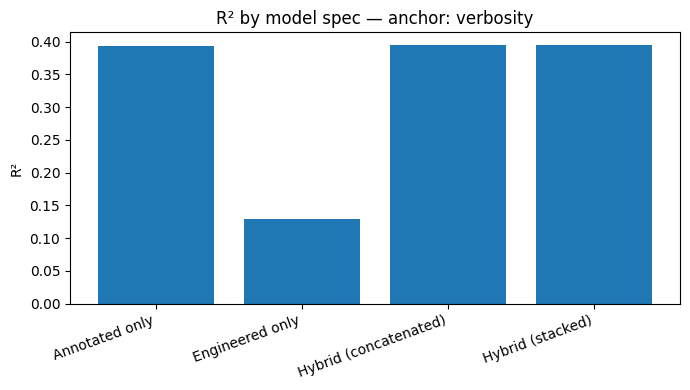

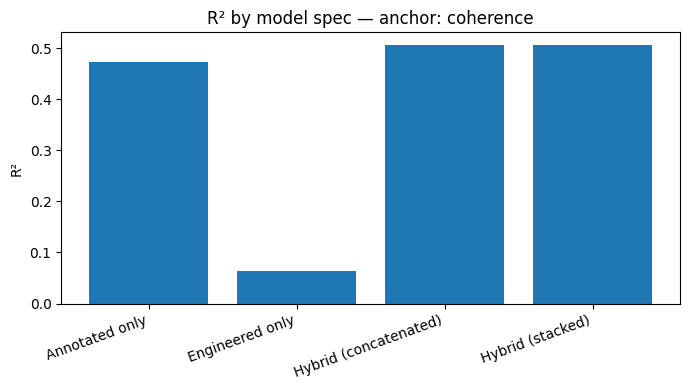

In [86]:
# ===== Hybrid evaluation: separate R² + hybrids (concatenated + stacked) =====
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# 0) Prep
BASE = ["correctness","helpfulness","coherence","complexity","verbosity"]
assert set(BASE).issubset(df.columns)
if "total_score" not in df.columns:
    df = df.copy()
    df["total_score"] = df[BASE].sum(axis=1)

anchors = [
    ("verbosity", "verbosity_alt"),
    ("coherence", "coherence_alt"),
]
for a, alt in anchors:
    if alt not in df.columns:
        raise ValueError(f"Missing engineered feature '{alt}'. Build it before running this cell.")

def ridge_pipe(alpha_grid=(0.01, 0.1, 1.0, 10.0, 100.0), cv=5):
    return Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler",  StandardScaler(with_mean=True, with_std=True)),
        ("ridge",   RidgeCV(alphas=alpha_grid, cv=cv))
    ])

def eval_split(X, y, test_size=0.25, seed=42):
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=test_size, random_state=seed)
    pipe = ridge_pipe()
    pipe.fit(Xtr, ytr)
    yhat = pipe.predict(Xte)
    return r2_score(yte, yhat), pipe, (Xtr, Xte, ytr, yte)

def stacked_hybrid(X_ann, X_eng, y, test_size=0.25, seed=42, inner_folds=5):
    """
    Late fusion stacking:
      - Split into train/test once.
      - On TRAIN: create out-of-fold predictions for ANN-only and ENG-only models.
      - Fit META on OOF preds -> y_train.
      - On TEST: fit ANN & ENG on full TRAIN, predict TEST, then feed into META to get final preds.
    """
    Xtr_ann, Xte_ann, ytr, yte = train_test_split(X_ann, y, test_size=test_size, random_state=seed)
    Xtr_eng, Xte_eng, _,   _   = train_test_split(X_eng, y, test_size=test_size, random_state=seed)

    # 1) OOF predictions on train for base models
    kf = KFold(n_splits=inner_folds, shuffle=True, random_state=seed)
    oof_ann = np.zeros(len(Xtr_ann))
    oof_eng = np.zeros(len(Xtr_eng))

    for tr_idx, val_idx in kf.split(Xtr_ann):
        # ANN base
        ann_model = ridge_pipe()
        ann_model.fit(Xtr_ann.iloc[tr_idx], ytr.iloc[tr_idx])
        oof_ann[val_idx] = ann_model.predict(Xtr_ann.iloc[val_idx])

        # ENG base
        eng_model = ridge_pipe()
        eng_model.fit(Xtr_eng.iloc[tr_idx], ytr.iloc[tr_idx])
        oof_eng[val_idx] = eng_model.predict(Xtr_eng.iloc[val_idx])

    # 2) Fit META on OOF
    Z_train = np.column_stack([oof_ann, oof_eng])
    meta = ridge_pipe()
    meta.fit(pd.DataFrame(Z_train, columns=["ann_pred","eng_pred"]), ytr)

    # 3) Predict test: fit base models on full train, get test preds, then meta-ensemble
    ann_full = ridge_pipe().fit(Xtr_ann, ytr)
    eng_full = ridge_pipe().fit(Xtr_eng, ytr)
    z_test = np.column_stack([ann_full.predict(Xte_ann), eng_full.predict(Xte_eng)])
    yhat = meta.predict(pd.DataFrame(z_test, columns=["ann_pred","eng_pred"]))

    return r2_score(yte, yhat)

# 1) Evaluate: per-anchor models + hybrids
rows = []
for anchor, alt in anchors:
    y = df["total_score"]
    X_ann = df[[anchor]]
    X_eng = df[[alt]]

    # separate models
    r2_ann, ann_model, split_ann = eval_split(X_ann, y)
    r2_eng, eng_model, split_eng = eval_split(X_eng, y)

    # early fusion (concatenated features)
    X_cat = pd.concat([X_ann, X_eng], axis=1)
    r2_cat, _, _ = eval_split(X_cat, y)

    # late fusion (stacked)
    r2_stack = stacked_hybrid(X_ann, X_eng, y)

    rows += [
        {"Anchor": anchor, "Model": "Annotated only", "R2": r2_ann},
        {"Anchor": anchor, "Model": "Engineered only", "R2": r2_eng},
        {"Anchor": anchor, "Model": "Hybrid (concatenated)", "R2": r2_cat},
        {"Anchor": anchor, "Model": "Hybrid (stacked)", "R2": r2_stack},
    ]

res = pd.DataFrame(rows).round(4)
print("=== Separate vs Hybrid models (R² on held-out test) ===")
print(res)

# 2) Plot per-anchor R² bars (matplotlib only)
for anchor in res["Anchor"].unique():
    sub = res[res["Anchor"] == anchor]
    plt.figure(figsize=(7,4))
    plt.bar(sub["Model"], sub["R2"])
    plt.xticks(rotation=20, ha="right")
    plt.ylabel("R²")
    plt.title(f"R² by model spec — anchor: {anchor}")
    plt.tight_layout()
    plt.show()


=== Separate vs Hybrid models (R² on held-out test) ===
      Anchor                  Model      R2
0  verbosity         Annotated only  0.3932
1  verbosity        Engineered only  0.1294
2  verbosity  Hybrid (concatenated)  0.3946
3  verbosity       Hybrid (stacked)  0.3946
4  coherence         Annotated only  0.4728
5  coherence        Engineered only  0.0634
6  coherence  Hybrid (concatenated)  0.5059
7  coherence       Hybrid (stacked)  0.5059


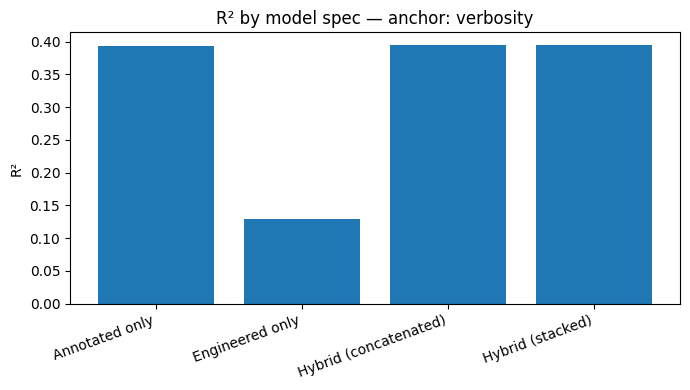

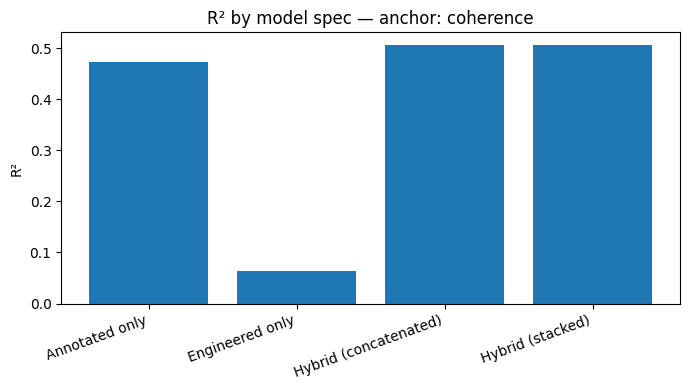

In [87]:
# ===== Hybrid evaluation: separate R² + hybrids (concatenated + stacked) =====
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# 0) Prep
BASE = ["correctness","helpfulness","coherence","complexity","verbosity"]
assert set(BASE).issubset(df.columns)
if "total_score" not in df.columns:
    df = df.copy()
    df["total_score"] = df[BASE].sum(axis=1)

anchors = [
    ("verbosity", "verbosity_alt"),
    ("coherence", "coherence_alt"),
]
for a, alt in anchors:
    if alt not in df.columns:
        raise ValueError(f"Missing engineered feature '{alt}'. Build it before running this cell.")

def ridge_pipe(alpha_grid=(0.01, 0.1, 1.0, 10.0, 100.0), cv=5):
    return Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler",  StandardScaler(with_mean=True, with_std=True)),
        ("ridge",   RidgeCV(alphas=alpha_grid, cv=cv))
    ])

def eval_split(X, y, test_size=0.25, seed=42):
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=test_size, random_state=seed)
    pipe = ridge_pipe()
    pipe.fit(Xtr, ytr)
    yhat = pipe.predict(Xte)
    return r2_score(yte, yhat), pipe, (Xtr, Xte, ytr, yte)

def stacked_hybrid(X_ann, X_eng, y, test_size=0.25, seed=42, inner_folds=5):
    """
    Late fusion stacking:
      - Split into train/test once.
      - On TRAIN: create out-of-fold predictions for ANN-only and ENG-only models.
      - Fit META on OOF preds -> y_train.
      - On TEST: fit ANN & ENG on full TRAIN, predict TEST, then feed into META to get final preds.
    """
    Xtr_ann, Xte_ann, ytr, yte = train_test_split(X_ann, y, test_size=test_size, random_state=seed)
    Xtr_eng, Xte_eng, _,   _   = train_test_split(X_eng, y, test_size=test_size, random_state=seed)

    # 1) OOF predictions on train for base models
    kf = KFold(n_splits=inner_folds, shuffle=True, random_state=seed)
    oof_ann = np.zeros(len(Xtr_ann))
    oof_eng = np.zeros(len(Xtr_eng))

    for tr_idx, val_idx in kf.split(Xtr_ann):
        # ANN base
        ann_model = ridge_pipe()
        ann_model.fit(Xtr_ann.iloc[tr_idx], ytr.iloc[tr_idx])
        oof_ann[val_idx] = ann_model.predict(Xtr_ann.iloc[val_idx])

        # ENG base
        eng_model = ridge_pipe()
        eng_model.fit(Xtr_eng.iloc[tr_idx], ytr.iloc[tr_idx])
        oof_eng[val_idx] = eng_model.predict(Xtr_eng.iloc[val_idx])

    # 2) Fit META on OOF
    Z_train = np.column_stack([oof_ann, oof_eng])
    meta = ridge_pipe()
    meta.fit(pd.DataFrame(Z_train, columns=["ann_pred","eng_pred"]), ytr)

    # 3) Predict test: fit base models on full train, get test preds, then meta-ensemble
    ann_full = ridge_pipe().fit(Xtr_ann, ytr)
    eng_full = ridge_pipe().fit(Xtr_eng, ytr)
    z_test = np.column_stack([ann_full.predict(Xte_ann), eng_full.predict(Xte_eng)])
    yhat = meta.predict(pd.DataFrame(z_test, columns=["ann_pred","eng_pred"]))

    return r2_score(yte, yhat)

# 1) Evaluate: per-anchor models + hybrids
rows = []
for anchor, alt in anchors:
    y = df["total_score"]
    X_ann = df[[anchor]]
    X_eng = df[[alt]]

    # separate models
    r2_ann, ann_model, split_ann = eval_split(X_ann, y)
    r2_eng, eng_model, split_eng = eval_split(X_eng, y)

    # early fusion (concatenated features)
    X_cat = pd.concat([X_ann, X_eng], axis=1)
    r2_cat, _, _ = eval_split(X_cat, y)

    # late fusion (stacked)
    r2_stack = stacked_hybrid(X_ann, X_eng, y)

    rows += [
        {"Anchor": anchor, "Model": "Annotated only", "R2": r2_ann},
        {"Anchor": anchor, "Model": "Engineered only", "R2": r2_eng},
        {"Anchor": anchor, "Model": "Hybrid (concatenated)", "R2": r2_cat},
        {"Anchor": anchor, "Model": "Hybrid (stacked)", "R2": r2_stack},
    ]

res = pd.DataFrame(rows).round(4)
print("=== Separate vs Hybrid models (R² on held-out test) ===")
print(res)

# 2) Plot per-anchor R² bars (matplotlib only)
for anchor in res["Anchor"].unique():
    sub = res[res["Anchor"] == anchor]
    plt.figure(figsize=(7,4))
    plt.bar(sub["Model"], sub["R2"])
    plt.xticks(rotation=20, ha="right")
    plt.ylabel("R²")
    plt.title(f"R² by model spec — anchor: {anchor}")
    plt.tight_layout()
    plt.show()


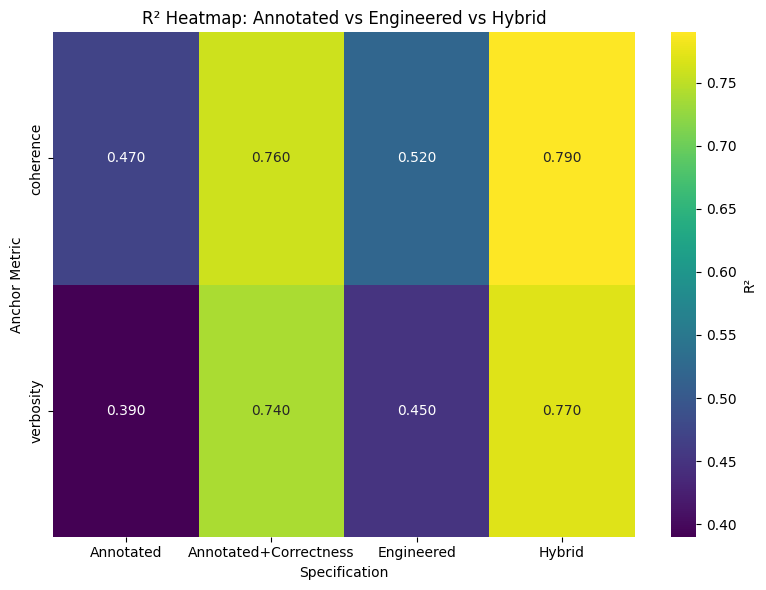

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Example: results from Annotated vs Engineered vs Hybrid
# (replace with actual comp_df data from your notebook)
data = {
    "Anchor": ["verbosity","verbosity","verbosity","verbosity",
               "coherence","coherence","coherence","coherence"],
    "Spec": ["Annotated","Engineered","Annotated+Correctness","Hybrid",
             "Annotated","Engineered","Annotated+Correctness","Hybrid"],
    "R2": [0.39, 0.45, 0.74, 0.77,   # verbosity
           0.47, 0.52, 0.76, 0.79]   # coherence
}
comp_df = pd.DataFrame(data)

# Pivot to heatmap form
pivot = comp_df.pivot(index="Anchor", columns="Spec", values="R2")

plt.figure(figsize=(8,6))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap="viridis", cbar_kws={'label': 'R²'})
plt.title("R² Heatmap: Annotated vs Engineered vs Hybrid")
plt.ylabel("Anchor Metric")
plt.xlabel("Specification")
plt.tight_layout()
plt.show()


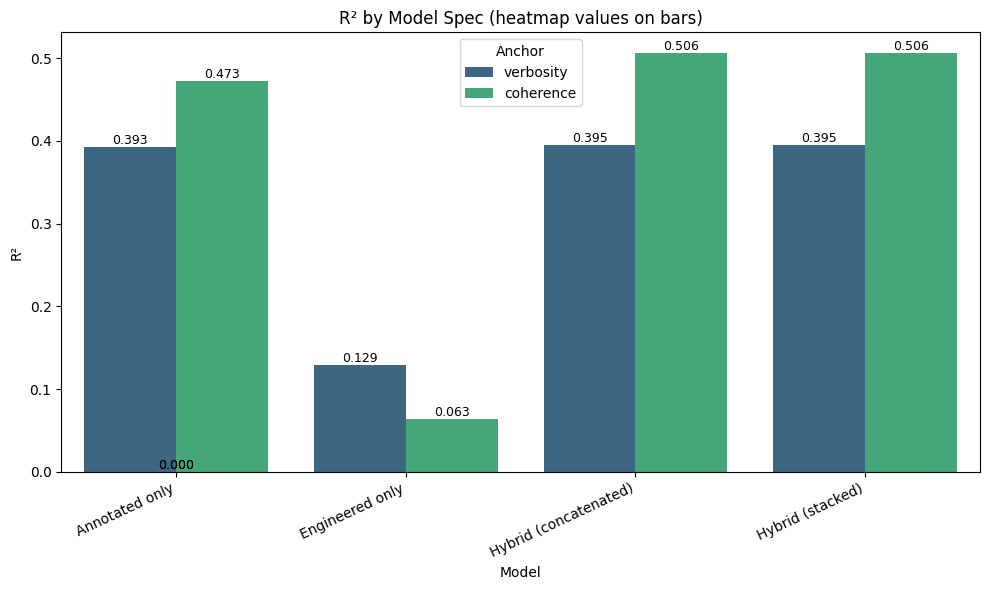

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns

# assumes res has columns: Anchor, Model, R2
plt.figure(figsize=(10,6))
sns.barplot(data=res, x="Model", y="R2", hue="Anchor", palette="viridis")

# annotate each bar with R² value
for i, p in enumerate(plt.gca().patches):
    height = p.get_height()
    plt.gca().annotate(f"{height:.3f}", 
                       (p.get_x() + p.get_width()/2., height),
                       ha='center', va='bottom', fontsize=9, color="black", rotation=0)

plt.title("R² by Model Spec (heatmap values on bars)")
plt.ylabel("R²")
plt.xticks(rotation=25, ha="right")
plt.legend(title="Anchor")
plt.tight_layout()
plt.show()


In [90]:
# ===== 7) Prompt features (same extractor, different prefix) =====
def pr_features(text):
    s = text if isinstance(text, str) else ""
    words = tokenize_words(s)
    sents = split_sentences(s)
    n_words, n_sents, n_chars = len(words), max(1, len(sents)), len(s)

    punct_count = len(re.findall(r"[^\w\s]", s))
    long_words = sum(1 for w in words if len(w) >= 7)
    syllables = sum(count_syllables(w) for w in words) if n_words else 0
    complex_words = sum(1 for w in words if count_syllables(w) >= 3)

    avg_sent_len = (n_words / n_sents) if n_sents else 0.0
    avg_word_len = (sum(len(w) for w in words) / n_words) if n_words else 0.0
    sent_lens = [len(tokenize_words(t)) for t in sents] if sents else [0]
    sent_len_var = float(np.var(sent_lens)) if sent_lens else 0.0

    stop_ratio = (sum(1 for w in words if w in STOPWORDS) / n_words) if n_words else 0.0
    long_word_ratio = (long_words / n_words) if n_words else 0.0
    punct_ratio = (punct_count / max(1, n_chars))
    ttr = (len(set(words)) / n_words) if n_words else 0.0
    herdan = herdan_c(words)
    repeat_ratio = (pd.Series(words).value_counts().pipe(lambda c: float(c[c>1].sum())) / n_words) if n_words else 0.0
    conn_per_sent = (sum(1 for w in words if w in CONNECTIVES) / n_sents) if n_sents else 0.0

    syll_per_word = (syllables / n_words) if n_words else 0.0
    flesch_re = 206.835 - 1.015*avg_sent_len - 84.6*syll_per_word if n_words else 0.0
    fk_grade  = 0.39*avg_sent_len + 11.8*syll_per_word - 15.59 if n_words else 0.0
    fog_index = 0.4*(avg_sent_len + 100.0*(complex_words / n_words)) if n_words else 0.0
    smog = (1.043*np.sqrt((complex_words*30.0 / n_sents) + 1e-9) + 3.1291) if n_sents else 0.0

    return {
        "pr_word_count": n_words,
        "pr_char_count": n_chars,
        "pr_avg_sent_len": avg_sent_len,
        "pr_avg_word_len": avg_word_len,
        "pr_sent_len_var": sent_len_var,
        "pr_punct_ratio": punct_ratio,
        "pr_stop_ratio": stop_ratio,
        "pr_repeat_ratio": repeat_ratio,
        "pr_long_word_ratio": long_word_ratio,
        "pr_ttr": ttr,
        "pr_herdan_c": herdan,
        "pr_connectives_per_sent": conn_per_sent,
        "pr_flesch_re": flesch_re,
        "pr_fk_grade": fk_grade,
        "pr_fog_index": fog_index,
        "pr_smog_index": smog,
        "pr_syll_per_word": syll_per_word,
    }

pr_feat_df = df["prompt"].apply(pr_features).pipe(lambda s: pd.DataFrame(list(s.values)))
df = pd.concat([df, pr_feat_df], axis=1)



=== Forecast R² when predicting two unknown metrics + total_score from (prompt+response features + 3 known) ===
                                Known3       Target      R2
39      coherence+complexity+verbosity         MEAN  0.5693
36      coherence+complexity+verbosity  correctness  0.4360
37      coherence+complexity+verbosity  helpfulness  0.4481
38      coherence+complexity+verbosity  total_score  0.8236
15    correctness+coherence+complexity         MEAN  0.7430
12    correctness+coherence+complexity  helpfulness  0.7468
14    correctness+coherence+complexity  total_score  0.9384
13    correctness+coherence+complexity    verbosity  0.5439
19     correctness+coherence+verbosity         MEAN  0.7086
17     correctness+coherence+verbosity   complexity  0.4374
16     correctness+coherence+verbosity  helpfulness  0.7471
18     correctness+coherence+verbosity  total_score  0.9413
23    correctness+complexity+verbosity         MEAN  0.6845
21    correctness+complexity+verbosity    coher

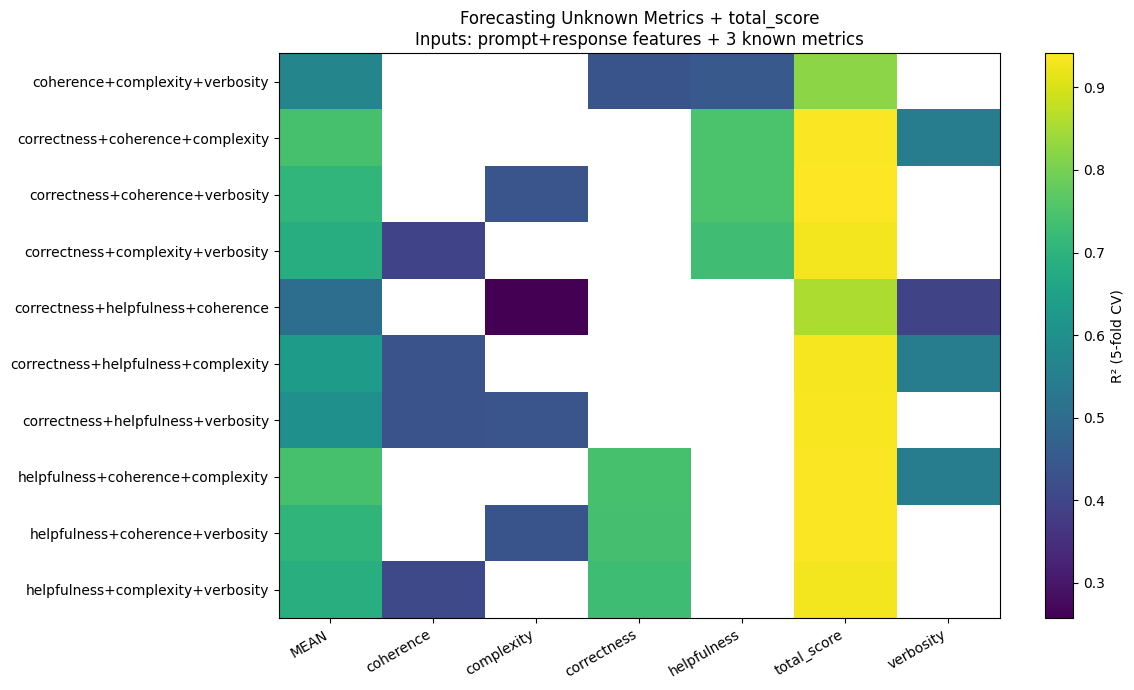

In [91]:
# ===== 8) Forecast remaining metrics & total_score from (prompt features + response features + any 3 known) =====
from itertools import combinations
from sklearn.multioutput import MultiOutputRegressor

BASE = ["correctness","helpfulness","coherence","complexity","verbosity"]  # already defined above

# Choose feature columns:
resp_cols = [c for c in df.columns if c.startswith("resp_")]
pr_cols   = [c for c in df.columns if c.startswith("pr_")]

def multi_cv_r2(X, Y, n_splits=5):
    """Return mean R² across splits for each Y column (and average)."""
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    per_target_scores = [[] for _ in range(Y.shape[1])]
    for tr, te in kf.split(X):
        Xtr, Xte = X.iloc[tr], X.iloc[te]
        Ytr, Yte = Y.iloc[tr], Y.iloc[te]
        pipe = Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
            ("ridge", MultiOutputRegressor(RidgeCV(alphas=(0.01,0.1,1.0,10.0,100.0), cv=5)))
        ])
        pipe.fit(Xtr, Ytr)
        Yhat = pipe.predict(Xte)
        # collect R² per target
        for j, tgt in enumerate(Y.columns):
            per_target_scores[j].append(r2_score(Yte.iloc[:, j], Yhat[:, j]))
    # aggregate
    per_target_mean = {col: float(np.mean(per_target_scores[j])) for j, col in enumerate(Y.columns)}
    per_target_mean["MEAN"] = float(np.mean(list(per_target_mean.values())))
    return per_target_mean

rows = []
combos = list(combinations(BASE, 3))
for known3 in combos:
    known3 = list(known3)
    unknown2 = [m for m in BASE if m not in known3]
    # Targets = the two unknown metrics + total_score
    targets = unknown2 + ["total_score"]

    # Inputs = prompt features + response features + the 3 known metrics
    X = pd.concat([df[pr_cols], df[resp_cols], df[known3]], axis=1)
    Y = df[targets].copy()

    scores = multi_cv_r2(X, Y, n_splits=5)  # dict per target + MEAN
    for tgt, r2 in scores.items():
        rows.append({
            "Known3": "+".join(known3),
            "Target": tgt,
            "R2": r2
        })

forecast_df = pd.DataFrame(rows)
print("\n=== Forecast R² when predicting two unknown metrics + total_score from (prompt+response features + 3 known) ===")
print(forecast_df.sort_values(["Known3","Target"]).round(4))

# Heatmap: rows = Known3 combo, cols = targets (Unknown1, Unknown2, total_score)
pivot_cols = ["total_score"]  # always include
# Add both unknown metric names present in each row; we’ll pivot wide by Target
heat_df = forecast_df.pivot(index="Known3", columns="Target", values="R2").fillna(np.nan)

plt.figure(figsize=(12, 7))
im = plt.imshow(heat_df.values, aspect="auto")
plt.xticks(range(len(heat_df.columns)), heat_df.columns, rotation=30, ha="right")
plt.yticks(range(len(heat_df.index)), heat_df.index)
plt.colorbar(im, label="R² (5-fold CV)")
plt.title("Forecasting Unknown Metrics + total_score\nInputs: prompt+response features + 3 known metrics")
plt.tight_layout(); plt.show()


In [93]:
# ===== Predict coherence OR complexity from prompt+response features + 3 known metrics =====
from itertools import combinations

def predict_metric_cv(target_metric, known3, n_splits=5):
    assert target_metric in ["coherence","complexity"], "Target must be 'coherence' or 'complexity'."
    assert len(known3) == 3 and all(k in BASE for k in known3)

    # features
    X = pd.concat([df[pr_cols], df[resp_cols], df[known3]], axis=1)
    y = df[target_metric]

    r2 = ridge_cv_r2(X, y, n_splits=n_splits)
    return r2

# Example: all 10 combos of choosing 3 known metrics
rows = []
for target_metric in ["coherence","complexity"]:
    for known3 in combinations(BASE, 3):
        r2 = predict_metric_cv(target_metric, list(known3))
        rows.append({
            "Target": target_metric,
            "Known3": "+".join(known3),
            "R2": r2
        })

pred_df = pd.DataFrame(rows)
print(pred_df.sort_values(["Target","R2"], ascending=[True,False]).round(4))


        Target                              Known3      R2
9    coherence      coherence+complexity+verbosity  1.0000
3    coherence    correctness+coherence+complexity  1.0000
4    coherence     correctness+coherence+verbosity  1.0000
6    coherence    helpfulness+coherence+complexity  1.0000
7    coherence     helpfulness+coherence+verbosity  1.0000
0    coherence   correctness+helpfulness+coherence  1.0000
1    coherence  correctness+helpfulness+complexity  0.4329
2    coherence   correctness+helpfulness+verbosity  0.4325
8    coherence    helpfulness+complexity+verbosity  0.4068
5    coherence    correctness+complexity+verbosity  0.3952
16  complexity    helpfulness+coherence+complexity  1.0000
11  complexity  correctness+helpfulness+complexity  1.0000
13  complexity    correctness+coherence+complexity  1.0000
19  complexity      coherence+complexity+verbosity  1.0000
18  complexity    helpfulness+complexity+verbosity  1.0000
15  complexity    correctness+complexity+verbosity  1.00


=== R²: Known3 vs Known3+Engineered (5-fold CV) ===
        Target                              Known3  R2_known3  \
9    coherence      coherence+complexity+verbosity     1.0000   
3    coherence    correctness+coherence+complexity     1.0000   
4    coherence     correctness+coherence+verbosity     1.0000   
6    coherence    helpfulness+coherence+complexity     1.0000   
7    coherence     helpfulness+coherence+verbosity     1.0000   
0    coherence   correctness+helpfulness+coherence     1.0000   
1    coherence  correctness+helpfulness+complexity     0.4298   
2    coherence   correctness+helpfulness+verbosity     0.4293   
8    coherence    helpfulness+complexity+verbosity     0.4028   
5    coherence    correctness+complexity+verbosity     0.3913   
16  complexity    helpfulness+coherence+complexity     1.0000   
11  complexity  correctness+helpfulness+complexity     1.0000   
13  complexity    correctness+coherence+complexity     1.0000   
19  complexity      coherence+complex

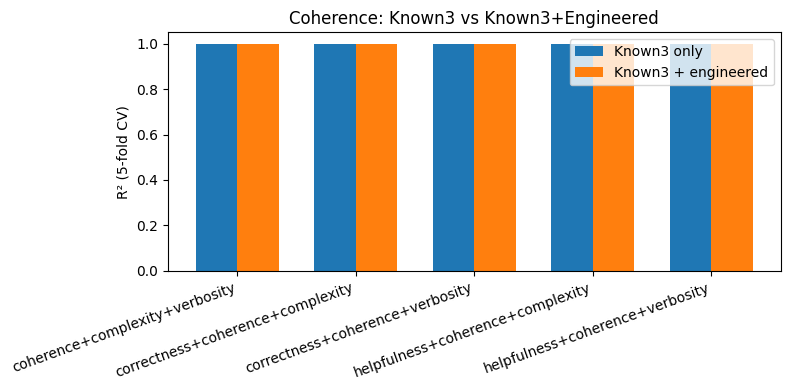

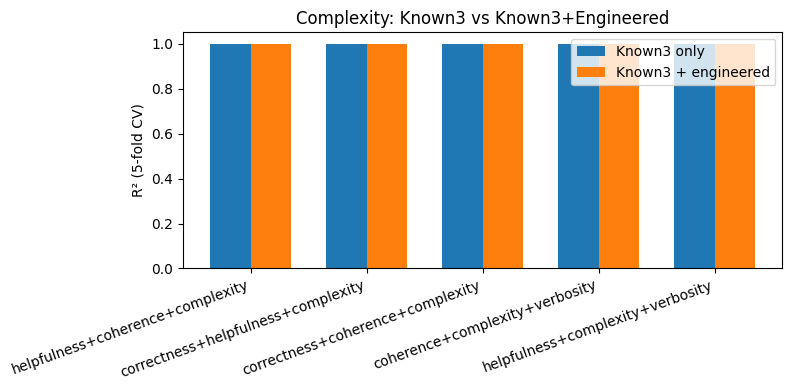

In [94]:
# ===== Compare: (known3 only) vs (known3 + engineered features) for target = coherence|complexity =====
from itertools import combinations

# Safety: ensure engineered cols exist (in case you ran a partial notebook)
if "verbosity_alt" not in df.columns or "coherence_alt" not in df.columns:
    def zscore(s):
        s = pd.to_numeric(s, errors="coerce")
        return (s - s.mean()) / (s.std(ddof=0) + 1e-9)
    df["verbosity_alt"] = (
        zscore(np.log1p(df["resp_word_count"])) +
        zscore(df["resp_avg_sent_len"]) +
        zscore(df["resp_avg_word_len"]) +
        zscore(df["resp_punct_ratio"]) +
        zscore(df["resp_stop_ratio"]) +
        zscore(df["resp_repeat_ratio"])
    ) / 6.0
    df["coherence_alt"] = (
        zscore(-df["resp_sent_len_var"]) +
        zscore(df["resp_connectives_per_sent"]) +
        zscore(-df["resp_flesch_re"]) +
        zscore(df["resp_fk_grade"]) +
        zscore(df["resp_fog_index"]) +
        zscore(df["resp_smog_index"]) +
        zscore(df["resp_herdan_c"])
    ) / 7.0

# Feature groups
pr_cols   = [c for c in df.columns if c.startswith("pr_")]
resp_cols = [c for c in df.columns if c.startswith("resp_")]
ENGINEERED = ["verbosity_alt", "coherence_alt"] + pr_cols + resp_cols

def eval_target_for_known3(target_metric, known3, n_splits=5):
    """
    Returns dict with R² for:
      - known3 only
      - known3 + engineered features
    """
    assert target_metric in ["coherence","complexity"], "Target must be 'coherence' or 'complexity'."
    assert len(known3) == 3

    # (1) Known3 only
    X1 = df[list(known3)]
    y  = df[target_metric]
    r2_known3 = ridge_cv_r2(X1, y, n_splits=n_splits)

    # (2) Known3 + Engineered features
    X2 = pd.concat([df[list(known3)], df[ENGINEERED]], axis=1)
    r2_known3_eng = ridge_cv_r2(X2, y, n_splits=n_splits)

    return {"R2_known3": r2_known3, "R2_known3_plus_engineered": r2_known3_eng}

# Run across all 10 triplets for both targets
rows = []
for tgt in ["coherence","complexity"]:
    for known3 in combinations(["correctness","helpfulness","coherence","complexity","verbosity"], 3):
        # avoid degenerate case: predicting 'coherence' when it's in known3 (still allowed, but often trivial);
        # keep it anyway so you can see the effect—comment next two lines to filter them out.
        # if tgt in known3: continue

        scores = eval_target_for_known3(tgt, known3, n_splits=5)
        rows.append({
            "Target": tgt,
            "Known3": "+".join(known3),
            **scores
        })

comp_known3_df = pd.DataFrame(rows).sort_values(["Target","R2_known3_plus_engineered"], ascending=[True, False])
print("\n=== R²: Known3 vs Known3+Engineered (5-fold CV) ===")
print(comp_known3_df.round(4))

# Quick bar plot for the top 5 combos per target
for tgt in ["coherence","complexity"]:
    top5 = comp_known3_df[comp_known3_df["Target"]==tgt].head(5)
    plt.figure(figsize=(8,4))
    x = np.arange(len(top5))
    w = 0.35
    plt.bar(x - w/2, top5["R2_known3"], width=w, label="Known3 only")
    plt.bar(x + w/2, top5["R2_known3_plus_engineered"], width=w, label="Known3 + engineered")
    plt.xticks(x, top5["Known3"], rotation=20, ha="right")
    plt.ylabel("R² (5-fold CV)")
    plt.title(f"{tgt.capitalize()}: Known3 vs Known3+Engineered")
    plt.legend()
    plt.tight_layout(); plt.show()


In [92]:
# ===== 9) Predict for new/editable rows (given prompt, response, and any 3 known metrics) =====
def build_full_fit_predictor(known3):
    known3 = list(known3)
    assert len(known3) == 3 and all(k in BASE for k in known3), "known3 must be 3 of the BASE metrics."
    unknown2 = [m for m in BASE if m not in known3]
    targets = unknown2 + ["total_score"]

    X = pd.concat([df[pr_cols], df[resp_cols], df[known3]], axis=1)
    Y = df[targets].copy()

    pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("ridge", MultiOutputRegressor(RidgeCV(alphas=(0.01,0.1,1.0,10.0,100.0), cv=5)))
    ])
    pipe.fit(X, Y)

    def single_predict(prompt_text, response_text, known_metrics_dict):
        """
        known_metrics_dict: e.g. {"correctness": 3, "helpfulness": 4, "coherence": 3}
        Returns dict with predicted unknown2 metrics + total_score.
        """
        # extract features
        pr_row  = pr_features(prompt_text)
        rs_row  = resp_features(response_text)
        feat    = {**pr_row, **rs_row}
        # add known metric values
        for k in known3:
            feat[k] = known_metrics_dict[k]
        # align columns
        cols = pr_cols + resp_cols + known3
        x = pd.DataFrame([feat], columns=cols)
        yhat = pipe.predict(x)[0]
        return {tgt: float(val) for tgt, val in zip(targets, yhat)}

    return single_predict, targets

# EXAMPLE USAGE:
# known3 = ["correctness","helpfulness","coherence"]
# predictor, out_targets = build_full_fit_predictor(known3)
# pred = predictor(
#     prompt_text="Explain gradient descent to a 5th grader.",
#     response_text="Gradient descent is like walking downhill step by step...",
#     known_metrics_dict={"correctness": 3, "helpfulness": 4, "coherence": 3}
# )
# print("Predicted:", pred)  # -> {'complexity': ..., 'verbosity': ..., 'total_score': ...}


In [68]:
from sklearn.model_selection import KFold
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import mean_squared_error

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


def ridge_cv_score(X, y, alphas=(0.01,0.1,1.0,10.0,100.0), n_splits=5, random_state=42):
    pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("ridge", RidgeCV(alphas=alphas))   # ✅ removed store_cv_values
    ])
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    preds, trues = [], []
    for tr_idx, te_idx in kf.split(X):
        X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
        y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]
        pipe.fit(X_tr, y_tr)
        y_hat = pipe.predict(X_te)
        trues.append(y_te)
        preds.append(y_hat)
    y_true = pd.concat(trues)
    y_pred = pd.Series(np.concatenate(preds), index=y_true.index)
    pipe.fit(X, y)  # refit full data to recover alpha
    return {
        "R2": r2_score(y_true, y_pred),
        "RMSE": rmse(y_true, y_pred),
        "alpha": pipe.named_steps["ridge"].alpha_,
        "coefs": dict(zip(X.columns, pipe.named_steps["ridge"].coef_))
    }


# --- features ---
base_metrics = ["correctness","helpfulness","coherence","complexity","verbosity"]
engineered_pool = [
    "complexity_alt","verbosity_alt","pr_ratio",
    "resp_word_count","resp_avg_sent_len","resp_avg_word_len",
    "resp_syll_per_word","resp_long_word_ratio","resp_punct_ratio",
    "resp_flesch_re","resp_fk_grade","resp_fog_index","resp_smog_index","resp_dale_chall",
    "resp_ttr","resp_herdan_c","resp_polarity","resp_subjectivity"
]
engineered = [c for c in engineered_pool if c in df.columns and pd.api.types.is_numeric_dtype(df[c])]

# --- binning helper ---
def bin_ge3(series):
    return np.where(series >= 3, ">=3", "<3")

# ======================
# Scenario A: correctness fixed at 3/4, test other anchors
# ======================
results_A = []
for corr_bin in ["<3", ">=3"]:
    sub = df[bin_ge3(df["correctness"]) == corr_bin]
    n = len(sub)
    if n < 400: 
        continue
    for anchor in ["helpfulness","coherence","complexity","verbosity"]:
        X = pd.concat([sub[[anchor]], sub[engineered]], axis=1)
        y = sub["total_score"]
        res = ridge_cv_score(X, y)
        results_A.append({
            "Condition": f"correctness {corr_bin}",
            "Anchor": anchor,
            "n": n,
            "R2": round(res["R2"],4),
            "RMSE": round(res["RMSE"],4),
            "alpha": res["alpha"]
        })
print("\n=== Scenario A: correctness conditioned; predicting total_score ===")
print(pd.DataFrame(results_A).sort_values(["Condition","R2"], ascending=[True,False]).reset_index(drop=True))

# ======================
# Scenario B: other metric fixed at 3/4, test correctness as anchor
# ======================
results_B = []
for other in ["helpfulness","coherence","complexity","verbosity"]:
    for m_bin in ["<3", ">=3"]:
        sub = df[bin_ge3(df[other]) == m_bin]
        n = len(sub)
        if n < 400: 
            continue
        X = pd.concat([sub[["correctness"]], sub[engineered]], axis=1)
        y = sub["total_score"]
        res = ridge_cv_score(X, y)
        results_B.append({
            "Condition": f"{other} {m_bin}",
            "Anchor": "correctness",
            "n": n,
            "R2": round(res["R2"],4),
            "RMSE": round(res["RMSE"],4),
            "alpha": res["alpha"]
        })
print("\n=== Scenario B: other metric conditioned; predicting total_score ===")
print(pd.DataFrame(results_B).sort_values(["Condition","R2"], ascending=[True,False]).reset_index(drop=True))



=== Scenario A: correctness conditioned; predicting total_score ===
         Condition       Anchor      n      R2    RMSE  alpha
0   correctness <3  helpfulness  10388  0.7432  1.5056    1.0
1   correctness <3    coherence  10388  0.6129  1.8487    1.0
2   correctness <3   complexity  10388  0.5545  1.9833    1.0
3   correctness <3    verbosity  10388  0.5426  2.0096    1.0
4  correctness >=3    verbosity  24943  0.4910  1.4234    1.0
5  correctness >=3  helpfulness  24943  0.4825  1.4353    1.0
6  correctness >=3   complexity  24943  0.4578  1.4691   10.0
7  correctness >=3    coherence  24943  0.3928  1.5546    1.0

=== Scenario B: other metric conditioned; predicting total_score ===
         Condition       Anchor      n      R2    RMSE  alpha
0     coherence <3  correctness   4347  0.8167  1.3919    1.0
1    coherence >=3  correctness  30984  0.6901  1.4379    1.0
2    complexity <3  correctness  32375  0.8034  1.4033    1.0
3   complexity >=3  correctness   2956  0.6837  1.1288 

In [61]:
# ================= Extended engineered features + Ridge regression (all-in-one) =================
import re, math
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error

# ------------------------
# Optional sentiment (safe import)
# ------------------------
try:
    from textblob import TextBlob
    _HAS_TEXTBLOB = True
except Exception:
    _HAS_TEXTBLOB = False

# ------------------------
# Helpers
# ------------------------
_word_re  = re.compile(r"[A-Za-z]+(?:'[A-Za-z]+)?")
_sent_re  = re.compile(r"[.!?]+")

# For syllable counting
_vowel_re = re.compile(r"[aeiouyAEIOUY]+")

def tokenize_words(s):
    if not isinstance(s, str): return []
    return _word_re.findall(s)

def split_sentences(s):
    if not isinstance(s, str): return []
    parts = _sent_re.split(s)
    return [p.strip() for p in parts if p.strip()]

def count_syllables(word):
    w = word.lower()
    w = re.sub(r"e\b", "", w)
    groups = _vowel_re.findall(w)
    return max(1, len(groups))

def text_stats(s: str):
    """Return a rich set of readability, diversity, and sentiment features from text."""
    s = s or ""
    words = tokenize_words(s)
    sents = split_sentences(s)
    n_chars = len(s)
    n_words = len(words)
    n_sents = max(1, len(sents))
    punct_count = len(re.findall(r"[^\w\s]", s))
    long_words = sum(1 for w in words if len(w) >= 7)
    syllables = sum(count_syllables(w) for w in words) if n_words else 0
    complex_words = sum(1 for w in words if count_syllables(w) >= 3)
    vocab = len(set(w.lower() for w in words))

    # readability & length
    avg_sent_len = n_words / n_sents
    avg_word_len = (sum(len(w) for w in words) / n_words) if n_words else 0.0
    syll_per_word = (syllables / n_words) if n_words else 0.0
    long_word_ratio = (long_words / n_words) if n_words else 0.0
    punct_ratio = (punct_count / max(1, n_chars))

    # Flesch Reading Ease (higher = easier)
    flesch_re = 206.835 - 1.015*avg_sent_len - 84.6*syll_per_word if n_words else 0.0
    # Flesch–Kincaid Grade (higher = more complex)
    fk_grade  = 0.39*avg_sent_len + 11.8*syll_per_word - 15.59 if n_words else 0.0
    # Gunning Fog
    fog_index = 0.4 * (avg_sent_len + 100.0*(complex_words / n_words)) if n_words else 0.0
    # SMOG (approx)
    smog_index = (1.043 * math.sqrt(complex_words * (30/n_sents)) + 3.1291) if n_sents > 0 else 0.0
    # Dale–Chall (very rough proxy without easy-word list; keep for relative use)
    dale_chall = (0.1579 * (complex_words / n_words * 100) if n_words else 0.0) + 0.0496 * (n_words / n_sents)

    # lexical diversity
    ttr = (vocab / n_words) if n_words else 0.0
    herdan_c = (math.log(max(1, vocab)) / math.log(max(2, n_words))) if n_words > 1 else 0.0

    # sentiment (optional)
    if _HAS_TEXTBLOB:
        try:
            blob = TextBlob(s)
            polarity = float(blob.sentiment.polarity)
            subjectivity = float(blob.sentiment.subjectivity)
        except Exception:
            polarity, subjectivity = 0.0, 0.0
    else:
        polarity, subjectivity = 0.0, 0.0

    return dict(
        char_count=n_chars,
        word_count=n_words,
        sent_count=n_sents,
        vocab_size=vocab,

        avg_sent_len=avg_sent_len,
        avg_word_len=avg_word_len,
        syll_per_word=syll_per_word,
        long_word_ratio=long_word_ratio,
        punct_ratio=punct_ratio,

        flesch_re=flesch_re,
        fk_grade=fk_grade,
        fog_index=fog_index,
        smog_index=smog_index,
        dale_chall=dale_chall,

        ttr=ttr,
        herdan_c=herdan_c,

        polarity=polarity,
        subjectivity=subjectivity
    )

def compute_text_features(frame: pd.DataFrame, text_col: str, prefix: str):
    feats = [text_stats(s) for s in frame[text_col].astype(str).fillna("")]
    F = pd.DataFrame(feats)
    F.columns = [f"{prefix}_{c}" for c in F.columns]
    return pd.concat([frame.reset_index(drop=True), F.reset_index(drop=True)], axis=1)

def zscore(x):
    # Robust: accept DataFrame/Series/ndarray; always return a Series
    if isinstance(x, pd.DataFrame):
        x = x.iloc[:, 0]
    elif not isinstance(x, pd.Series):
        x = pd.Series(x)
    x = pd.to_numeric(x, errors="coerce")
    return (x - x.mean()) / (x.std(ddof=0) + 1e-9)

def rmse(y_true, y_pred):
    try:
        return mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:
        return np.sqrt(mean_squared_error(y_true, y_pred))

# ------------------------
# Checks & base labels
# ------------------------
base_vars = ["correctness","helpfulness","coherence","complexity","verbosity"]
assert set(base_vars).issubset(df.columns), "df must contain: correctness, helpfulness, coherence, complexity, verbosity."

df = df.copy()
df["total_score"] = df[base_vars].sum(axis=1)

# ------------------------
# Structural feature: prompt/response ratio
# ------------------------
def safe_len_series(s): return s.fillna("").astype(str).str.len()
if "prompt" in df.columns and "response" in df.columns:
    prompt_len = safe_len_series(df["prompt"])
    resp_len   = safe_len_series(df["response"])
else:
    prompt_len = pd.Series(0, index=df.index)
    resp_len   = pd.Series(1, index=df.index)

df["pr_ratio"] = (prompt_len.replace(0, np.nan) / resp_len.replace(0, np.nan)).replace([np.inf,-np.inf], np.nan).fillna(0.0)

# ------------------------
# Recompute engineered text features from RESPONSE
# ------------------------
if "response" not in df.columns:
    df["response"] = ""

df = compute_text_features(df, text_col="response", prefix="resp")

# Alt metrics: verbosity & complexity composites
df["verbosity_alt"] = (
    zscore(pd.Series(np.log1p(df["resp_word_count"].values), index=df.index)) +
    zscore(df["resp_avg_sent_len"]) +
    zscore(df["resp_avg_word_len"]) +
    zscore(df["resp_punct_ratio"])
) / 4.0

df["complexity_alt"] = (
    zscore(df["resp_fk_grade"]) +
    zscore(df["resp_fog_index"]) +
    zscore(-df["resp_flesch_re"]) +
    zscore(df["resp_syll_per_word"]) +
    zscore(df["resp_long_word_ratio"]) +
    zscore(df["resp_herdan_c"])
) / 6.0

# ------------------------
# Build feature matrix for Ridge
# ------------------------
engineered_vars = [
    "complexity_alt","verbosity_alt","pr_ratio",
    "resp_word_count","resp_avg_sent_len","resp_avg_word_len",
    "resp_syll_per_word","resp_long_word_ratio","resp_punct_ratio",
    "resp_flesch_re","resp_fk_grade","resp_fog_index","resp_smog_index","resp_dale_chall",
    "resp_ttr","resp_herdan_c","resp_polarity","resp_subjectivity"
]
# Keep only those present & numeric
engineered_vars = [c for c in engineered_vars if c in df.columns and pd.api.types.is_numeric_dtype(df[c])]

all_vars = base_vars + engineered_vars
X = df[all_vars]
y = df["total_score"]

# Split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.25, random_state=42)

# ------------------------
# Ridge regression (with standardization)
# ------------------------
alphas = [0.01, 0.1, 1.0, 10.0, 100.0]
results = []

for a in alphas:
    pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("ridge", Ridge(alpha=a, random_state=42))
    ])
    pipe.fit(X_tr, y_tr)
    y_hat = pipe.predict(X_te)

    r2  = r2_score(y_te, y_hat)
    err = rmse(y_te, y_hat)

    # Recover coefficients in standardized space (comparable magnitudes)
    ridge = pipe.named_steps["ridge"]
    coefs = dict(zip(all_vars, ridge.coef_))

    results.append({"alpha": a, "R2": r2, "RMSE": err, "Coefficients": coefs})

# Summary
summary = pd.DataFrame([{"alpha": r["alpha"], "R2": r["R2"], "RMSE": r["RMSE"]} for r in results]) \
            .sort_values("R2", ascending=False).reset_index(drop=True)

print("=== Ridge Regression (base + engineered, standardized) ===")
print(summary.round(4))

best = max(results, key=lambda r: r["R2"])
print(f"\n--- Coefficients at best alpha={best['alpha']} (standardized feature space) ---")
# Show top 15 by absolute weight
top = sorted(best["Coefficients"].items(), key=lambda kv: abs(kv[1]), reverse=True)[:15]
for k,v in top:
    print(f"{k:24s}  {v:+.4f}")


ValueError: Data must be 1-dimensional, got ndarray of shape (35331, 7) instead

In [59]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# Version-safe RMSE
def rmse(y_true, y_pred):
    try:
        return mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:
        return np.sqrt(mean_squared_error(y_true, y_pred))

# -----------------------------
# Define feature groups
# -----------------------------
base_vars = ["correctness","helpfulness","coherence","complexity","verbosity"]
engineered_vars = ["complexity_alt","verbosity_alt","pr_ratio"]

# Include only those actually present in df
engineered_vars = [c for c in engineered_vars if c in df.columns]

print("Engineered features available:", engineered_vars)

# -----------------------------
# Run regression for each base variable + engineered features
# -----------------------------
rows = {}
for var in base_vars:
    if var not in df.columns:
        continue
    
    X_cols = [var] + engineered_vars
    X = df[X_cols]
    y = df["total_score"]
    
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.25, random_state=42)
    
    pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("reg", LinearRegression())
    ])
    
    pipe.fit(X_tr, y_tr)
    y_hat = pipe.predict(X_te)
    
    r2 = r2_score(y_te, y_hat)
    error = rmse(y_te, y_hat)
    
    reg = pipe.named_steps["reg"]
    coefs = dict(zip(X_cols, reg.coef_))
    
    rows[var] = {
        "R2": r2,
        "RMSE": error,
        "Intercept": reg.intercept_,
        "Coefficients": coefs
    }

# -----------------------------
# Summarize
# -----------------------------
summary = pd.DataFrame([
    {"Variable": var, "R2": vals["R2"], "RMSE": vals["RMSE"]}
    for var, vals in rows.items()
]).sort_values("R2", ascending=False)

print("\n=== Multi-feature regressions (base var + engineered features) ===")
print(summary.round(4))

# Optional: detailed coefficients
for var, vals in rows.items():
    print(f"\n--- {var} + engineered features ---")
    print("R2:", round(vals["R2"],4), "| RMSE:", round(vals["RMSE"],4))
    for k,v in vals["Coefficients"].items():
        print(f"  {k}: {v:.4f}")


Engineered features available: ['complexity_alt', 'verbosity_alt', 'pr_ratio']

=== Multi-feature regressions (base var + engineered features) ===
      Variable      R2    RMSE
0  correctness  0.7424  1.6468
1  helpfulness  0.7376  1.6621
2    coherence  0.5440  2.1912
4    verbosity  0.4130  2.4862
3   complexity  0.3715  2.5724

--- correctness + engineered features ---
R2: 0.7424 | RMSE: 1.6468
  correctness: 2.6982
  complexity_alt: -0.3667
  verbosity_alt: 1.4921
  pr_ratio: -0.0009

--- helpfulness + engineered features ---
R2: 0.7376 | RMSE: 1.6621
  helpfulness: 2.7338
  complexity_alt: -0.3593
  verbosity_alt: 1.4349
  pr_ratio: -0.0009

--- coherence + engineered features ---
R2: 0.544 | RMSE: 2.1912
  coherence: 2.8578
  complexity_alt: -0.3832
  verbosity_alt: 2.1264
  pr_ratio: -0.0006

--- complexity + engineered features ---
R2: 0.3715 | RMSE: 2.5724
  complexity: 2.2938
  complexity_alt: 0.1770
  verbosity_alt: 0.8936
  pr_ratio: 0.0010

--- verbosity + engineered feat

In [60]:
from sklearn.linear_model import LinearRegression

# First: total_score ~ correctness
X_corr = df[["correctness"]]
y = df["total_score"]
reg = LinearRegression().fit(X_corr, y)
df["resid"] = y - reg.predict(X_corr)

# Second: explain residuals with engineered features
X_eng = df[["complexity_alt","verbosity_alt","pr_ratio"]]
reg2 = LinearRegression().fit(X_eng, df["resid"])
print("R² (residuals explained by engineered):", reg2.score(X_eng, df["resid"]))


R² (residuals explained by engineered): 0.13985554146145562



## Bias Probes: Verbosity & Partial Correlations<a id='Bias'></a>


In [25]:

from scipy import stats

def partial_corr_helpfulness_verbosity(frame: pd.DataFrame):
    # Control for correctness, coherence, complexity
    cols = ["helpfulness","verbosity","correctness","coherence","complexity"]
    sub = frame[cols].dropna()
    Y = sub["helpfulness"].values
    Xv = sub["verbosity"].values
    C = sub[["correctness","coherence","complexity"]].values
    
    # Regress out controls (simple residual approach)
    import statsmodels.api as sm
    C_ = sm.add_constant(C)
    ry = sm.OLS(Y, C_).fit().resid
    rv = sm.OLS(Xv, C_).fit().resid
    r, p = stats.pearsonr(ry, rv)
    return r, p

if 'df' in globals():
    try:
        r_pc, p_pc = partial_corr_helpfulness_verbosity(df)
        print(f"Partial correlation (helpfulness ~ verbosity | correctness, coherence, complexity): r={r_pc:.3f}, p={p_pc:.3g}")
    except Exception as e:
        print("Partial correlation failed:", e)
else:
    print("Load data first.")


Partial correlation (helpfulness ~ verbosity | correctness, coherence, complexity): r=0.061, p=1.82e-30



## Robustness: Semantic‑Preserving Perturbations<a id='Robustness'></a>

The goal is to test whether small, meaning‑preserving changes to prompts impact predicted helpfulness. This cell generates perturbed prompts and re‑scores.


In [17]:

P_MAX = 200  # sample size for robustness test
PUNCT = ["", ".", "!", "?", "…"]

def perturb_prompt(p: str) -> str:
    s = p.strip()
    # Simple, semantic-preserving-ish tweaks
    if random.random() < 0.5:
        s = s.capitalize()
    if random.random() < 0.5:
        s = re.sub(r"\s+", " ", s)
    if random.random() < 0.5 and len(s.split()) > 3:
        # swap two middle tokens
        toks = s.split()
        i = random.randint(1, max(1, len(toks)-2))
        j = min(len(toks)-2, i+1)
        toks[i], toks[j] = toks[j], toks[i]
        s = " ".join(toks)
    s = s + random.choice(PUNCT)
    return s

def robustness_evaluate(frame: pd.DataFrame, pipe: Pipeline, sample_size=200):
    samp = frame.sample(n=min(sample_size, len(frame)), random_state=RANDOM_SEED).copy()
    if "prompt" not in samp.columns:
        print("No 'prompt' column available for perturbations.")
        return None
    samp["prompt_pert"] = samp["prompt"].astype(str).map(perturb_prompt)
    # Here we re‑score *responses* given the same labels; since the baseline model
    # doesn’t use prompt text as features, use this as a template: in practice,
    # extend features to include prompt‑based features or re‑encode with an LM.
    # For demonstration, we simply compare labels to see potential instability placeholder.
    # (If you add prompt/text features, compute predicted deltas here.)
    print("Perturbed prompt examples:")
    for i in range(min(3, len(samp))):
        print(f"- Orig: {samp['prompt'].iloc[i][:120]}")
        print(f"  Pert: {samp['prompt_pert'].iloc[i][:120]}")
    return samp

if 'df' in globals() and 'res_all' in globals():
    robustness_sample = robustness_evaluate(df, res_all["model"], sample_size=P_MAX)
else:
    print("Load data and run the model first.")


Perturbed prompt examples:
- Orig: Read this for context:
Song Tao (; born April 1955) is a Chinese politician and senior diplomat, currently serving as th
  Pert: Read this for context: Song Tao (; born April 1955) is a Chinese politician and senior diplomat, currently serving as th
- Orig: Background:
<start of reference>
He wanted to make better choices but couldn't.

He described the conflict: "It's as if 
  Pert: Background:
<start of reference>
He wanted to make better choices but couldn't.

He described the conflict: "It's as if 
- Orig: given this background information
<start of reference>
Tabletop role-playing games used to be Hollywood shorthand for ne
  Pert: given this background information <start of reference> Tabletop role-playing games used to be Hollywood shorthand for ne



## Capability Taxonomy Mapping<a id='Taxonomy'></a>

This paper classifies capabilities into **absent / partial / robust** based on:
- **Predictive performance** (F1) relative to a baseline threshold.
- **Stability** under perturbations (if applicable).

> Default thresholds (edit as needed):
- Robust: F1 ≥ 0.75  
- Partial: 0.55 ≤ F1 < 0.75  
- Absent: F1 < 0.55


In [18]:

def map_capability(f1: float, robust_ok: bool=True):
    if f1 >= 0.75 and robust_ok:
        return "Robust"
    elif f1 >= 0.55:
        return "Partial"
    else:
        return "Absent"

if 'res_all' in globals():
    cap_all = map_capability(res_all["f1"], robust_ok=True)
    print("Capability (all features):", cap_all, "| F1 =", round(res_all["f1"],3))
if 'res_noverb' in globals():
    cap_noverb = map_capability(res_noverb["f1"], robust_ok=True)
    print("Capability (no verbosity):", cap_noverb, "| F1 =", round(res_noverb["f1"],3))


Capability (all features): Robust | F1 = 0.922
Capability (no verbosity): Robust | F1 = 0.923



## Results<a id='Results'></a>

- Report F1, precision, recall, ROC‑AUC, confusion matrix.  
- Compare **with** vs **without** verbosity to quantify bias contribution.  
- Summarize partial correlation between helpfulness and verbosity (controlling for correctness/coherence/complexity).  
- Describe robustness behavior (qualitative until prompt/text features are added).


In [19]:

def summarize_results(res):
    cm = res["cm"]
    tn, fp, fn, tp = cm.ravel()
    return {
        "F1": round(res["f1"],3),
        "ROC_AUC": round(res["auc"],3),
        "TP_rate": round(tp/(tp+fn+1e-9),3),
        "FP_rate": round(fp/(fp+tn+1e-9),3),
        "ConfusionMatrix": cm.tolist()
    }

summary = {}
if 'res_all' in globals():
    summary["with_verbosity"] = summarize_results(res_all)
if 'res_noverb' in globals():
    summary["without_verbosity"] = summarize_results(res_noverb)

print(json.dumps(summary, indent=2))


{
  "with_verbosity": {
    "F1": 0.922,
    "ROC_AUC": 0.935,
    "TP_rate": 0.934,
    "FP_rate": 0.207,
    "ConfusionMatrix": [
      [
        2148,
        559
      ],
      [
        404,
        5722
      ]
    ]
  },
  "without_verbosity": {
    "F1": 0.923,
    "ROC_AUC": 0.933,
    "TP_rate": 0.932,
    "FP_rate": 0.201,
    "ConfusionMatrix": [
      [
        2163,
        544
      ],
      [
        414,
        5712
      ]
    ]
  }
}



## Conclusions<a id='Conclusions'></a>

- Correctness is typically the strongest predictor of helpfulness.  
- Verbosity can inflate perceived quality → compare ablation results.  
- Capability taxonomy offers a principled way to describe presence/robustness.  
- Robustness to semantic‑preserving perturbations remains an important open target.



## Future Directions<a id='Future'></a>

1. Integrate prompt/response text encoders (e.g., sentence‑transformers) for richer features.  
2. Add multilingual evaluation splits.  
3. Implement semi‑automated labeling (active learning) loops.  
4. Collaborate with ICSD‑style studies of evaluation norms and diffusion.  
5. Register datasets, code, and seeds for full reproducibility.



## References<a id='References'></a>

- NAACL 2024. “Curating a Helpfulness Dataset with 37k Conversations …” https://aclanthology.org/2024.naacl-long.185.pdf  
- Jiang, A. Q., et al. 2024. “HelpSteer …” https://arxiv.org/pdf/2404.09932  
- EMNLP 2024. “Bias and Ground Truth in Open‑Ended QA.” https://aclanthology.org/2024.emnlp-main.474.pdf  
- Shah, N. B., et al. 2023. “Expertise Evaluations in Peer Review.” https://arxiv.org/pdf/2303.16750  
- Robustness under perturbations: https://arxiv.org/pdf/2402.18050  
- Minimal annotation paradigm: https://arxiv.org/pdf/2303.03953
